# Домашнее задание 1 - Вспомогательные задачи в СV



## Оценивание

Задание должно быть выполнено самостоятельно. Похожие решения будут считаться плагиатом. Если вы опирались на внешний источник в реализации, необходимо указать ссылку на него. 

В качестве решения, необходимо предоставить код + отчет, в котором будут отображены все детали выбора гиперпараметров, комментарии, сопровождающие графики, а так же ответы на вопросы в ДЗ. Оформляйте отчет четко и читаемо. Плохо оформленный код, плохо оформленные графики негативно скажутся на оценке, так же как и неэффективная реализация.


## Задание

Вам предстоит реализовать одну из вспомогательных задач &mdash; предсказание поворотов картинок (связанная статья - [Unsupervised Representation Learning by predicting Image Rotations](https://arxiv.org/pdf/1803.07728.pdf)). Возьмите датасет STL10, который прекрасно подходит под сеттинг предобучения без учителя. За архитектурное решение возьмите ResNet18. И датасет, и реализацию нейронки можно найти в библиотеке `torchvision` (`torchvision.datasets.STL10`, `torchvision.models.resnet.resnet18`). Для эффективности, используйте стандартные [оптимизации](https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html) для обучения, например `Automatic Mixed Precision`. При желании, можно попробовать `nvidia.dali`.

**NB** По каждому из нижепредставленных пунктов, необходимо указать явно использованные для  моделей гиперпараметры и визуализации кривых обучения всех обучаемых моделей.

### [Датасет STL-10](https://cs.stanford.edu/~acoates/stl10/)

В STL10 всего 10 классов, а все изображения имеют разрешение $96 \times 96$ пикселей, что отличается от ImageNet (1000 классов и $224\times224$). Нужно адаптировать модель к картинкам меньшего размера и меньшему числу классов (подсказка: `model.conv1, model.maxpool, model.fc`).
Далее, будем называть энкодером или `backbone` часть модели до последнего слоя (`model.fc`). Репрезентациями - выход с `model.avgpool`.

Две части датасета подходят под стадию предобучения и стадию обучения на конечной задаче.
Одна из них (`unlabeled`) состоит из 100 000 изображений без разметки. 
Другая -  с разметкой, 5 000 изображений обучающей выборки (`train`) и 8 000 изображений валидационной выборки (`test`). Разметка состоит из 10 классов: `airplane`, `bird`, `car`, `cat`, `deer`, `dog`, `horse`, `monkey`, `ship`, `truck`, так что в размеченной выборке 500 и 800 изображений на каждый класс, соответственно.



In [1]:
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader


batch_size = 512
transform = transforms.Compose([
    transforms.ToTensor(),
])

unlabeled_dataset = datasets.STL10(root='./data', split='unlabeled', download=True, transform=transform)
train_dataset = datasets.STL10(root='./data', split='train', download=True, transform=transform)
test_dataset = datasets.STL10(root='./data', split='test', download=True, transform=transform)

unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [2]:
test_dataset

Dataset STL10
    Number of datapoints: 8000
    Root location: ./data
    Split: test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


## 0. Supervised 1
(0 баллов)

Для начала сделайте бейзлайн. Обучите резнет на размеченной части датасета без аугментаций, используя `train` и `test` в соотвествующих целях. Зафиксируйте лучшее достигнутое вами качество, ~70% top-1 accuracy будет засчитано. 

**NB** Без этого бейзлайна, домашнее задание не будет считаться выполненным (0 баллов за все).


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm


def train(model, loader, criterion, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(loader, desc="Обучение", leave=False):
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type="cuda"):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / total, correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Валидация", leave=False):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            with torch.amp.autocast(device_type="cuda"):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / total, correct / total


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline = models.resnet18(pretrained=False)
baseline.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
baseline.fc = nn.Linear(baseline.fc.in_features, 10)
baseline = baseline.to(device)

learning_rate = 0.001
num_epochs = 40
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
scaler = torch.amp.GradScaler()

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    print(f"Эпоха {epoch + 1}/{num_epochs}")
    train_loss, train_acc = train(baseline, train_loader, criterion, optimizer, scaler, device)
    val_loss, val_acc = validate(baseline, test_loader, criterion, device)

    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Потери на обучении: {train_loss:.4f}, Точность на обучении: {train_acc:.4f}")
    print(f"Потери на валидации: {val_loss:.4f}, Точность на валидации: {val_acc:.4f}")


baseline_results = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accs": train_accs,
    "val_accs": val_accs
}
torch.save(baseline_results, "baseline_results.pth")
torch.save(baseline.state_dict(), "baseline_weights.pth")

c:\Users\sever\OneDrive\Рабочий стол\SSL\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sever\OneDrive\Рабочий стол\SSL\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Эпоха 1/40


Потери на обучении: 2.0828, Точность на обучении: 0.2684
Потери на валидации: 11.2130, Точность на валидации: 0.1042
Эпоха 2/40


Потери на обучении: 1.4952, Точность на обучении: 0.4320
Потери на валидации: 3.6901, Точность на валидации: 0.1973
Эпоха 3/40


Потери на обучении: 1.3127, Точность на обучении: 0.5022
Потери на валидации: 2.0878, Точность на валидации: 0.2750
Эпоха 4/40


Потери на обучении: 1.1478, Точность на обучении: 0.5700
Потери на валидации: 1.7525, Точность на валидации: 0.3515
Эпоха 5/40


Потери на обучении: 1.0172, Точность на обучении: 0.6296
Потери на валидации: 1.5611, Точность на валидации: 0.4462
Эпоха 6/40


Потери на обучении: 0.8903, Точность на обучении: 0.6760
Потери на валидации: 1.6796, Точность на валидации: 0.4434
Эпоха 7/40


Потери на обучении: 0.7698, Точность на обучении: 0.7178
Потери на валидации: 1.6185, Точность на валидации: 0.4793
Эпоха 8/40


Потери на обучении: 0.6180, Точность на обучении: 0.7790
Потери на валидации: 1.4161, Точность на валидации: 0.5315
Эпоха 9/40


Потери на обучении: 0.5136, Точность на обучении: 0.8248
Потери на валидации: 1.4214, Точность на валидации: 0.5396
Эпоха 10/40


Потери на обучении: 0.3836, Точность на обучении: 0.8706
Потери на валидации: 1.4968, Точность на валидации: 0.5471
Эпоха 11/40


Потери на обучении: 0.2304, Точность на обучении: 0.9308
Потери на валидации: 1.7466, Точность на валидации: 0.5489
Эпоха 12/40


Потери на обучении: 0.1567, Точность на обучении: 0.9522
Потери на валидации: 1.4622, Точность на валидации: 0.6071
Эпоха 13/40


Потери на обучении: 0.0918, Точность на обучении: 0.9742
Потери на валидации: 3.3740, Точность на валидации: 0.4943
Эпоха 14/40


Потери на обучении: 0.0653, Точность на обучении: 0.9848
Потери на валидации: 1.4862, Точность на валидации: 0.5960
Эпоха 15/40


Потери на обучении: 0.0382, Точность на обучении: 0.9924
Потери на валидации: 1.4582, Точность на валидации: 0.6206
Эпоха 16/40


Потери на обучении: 0.0208, Точность на обучении: 0.9984
Потери на валидации: 1.5444, Точность на валидации: 0.6246
Эпоха 17/40


Потери на обучении: 0.0125, Точность на обучении: 0.9984
Потери на валидации: 1.6152, Точность на валидации: 0.6064
Эпоха 18/40


Потери на обучении: 0.0060, Точность на обучении: 0.9996
Потери на валидации: 1.3386, Точность на валидации: 0.6560
Эпоха 19/40


Потери на обучении: 0.0029, Точность на обучении: 1.0000
Потери на валидации: 1.2905, Точность на валидации: 0.6669
Эпоха 20/40


Потери на обучении: 0.0018, Точность на обучении: 1.0000
Потери на валидации: 1.2814, Точность на валидации: 0.6686
Эпоха 21/40


Потери на обучении: 0.0014, Точность на обучении: 1.0000
Потери на валидации: 1.2644, Точность на валидации: 0.6736
Эпоха 22/40


Потери на обучении: 0.0011, Точность на обучении: 1.0000
Потери на валидации: 1.2524, Точность на валидации: 0.6753
Эпоха 23/40


Потери на обучении: 0.0010, Точность на обучении: 1.0000
Потери на валидации: 1.2503, Точность на валидации: 0.6736
Эпоха 24/40


Потери на обучении: 0.0010, Точность на обучении: 1.0000
Потери на валидации: 1.2510, Точность на валидации: 0.6721
Эпоха 25/40


Потери на обучении: 0.0008, Точность на обучении: 1.0000
Потери на валидации: 1.2520, Точность на валидации: 0.6733
Эпоха 26/40


Потери на обучении: 0.0009, Точность на обучении: 1.0000
Потери на валидации: 1.2506, Точность на валидации: 0.6740
Эпоха 27/40


Потери на обучении: 0.0008, Точность на обучении: 1.0000
Потери на валидации: 1.2508, Точность на валидации: 0.6733
Эпоха 28/40


Потери на обучении: 0.0008, Точность на обучении: 1.0000
Потери на валидации: 1.2510, Точность на валидации: 0.6735
Эпоха 29/40


Потери на обучении: 0.0007, Точность на обучении: 1.0000
Потери на валидации: 1.2518, Точность на валидации: 0.6737
Эпоха 30/40


Потери на обучении: 0.0007, Точность на обучении: 1.0000
Потери на валидации: 1.2524, Точность на валидации: 0.6734
Эпоха 31/40


Потери на обучении: 0.0007, Точность на обучении: 1.0000
Потери на валидации: 1.2521, Точность на валидации: 0.6739
Эпоха 32/40


Потери на обучении: 0.0007, Точность на обучении: 1.0000
Потери на валидации: 1.2520, Точность на валидации: 0.6740
Эпоха 33/40


Потери на обучении: 0.0007, Точность на обучении: 1.0000
Потери на валидации: 1.2523, Точность на валидации: 0.6746
Эпоха 34/40


Потери на обучении: 0.0006, Точность на обучении: 1.0000
Потери на валидации: 1.2517, Точность на валидации: 0.6751
Эпоха 35/40


Потери на обучении: 0.0007, Точность на обучении: 1.0000
Потери на валидации: 1.2516, Точность на валидации: 0.6746
Эпоха 36/40


Потери на обучении: 0.0006, Точность на обучении: 1.0000
Потери на валидации: 1.2527, Точность на валидации: 0.6753
Эпоха 37/40


Потери на обучении: 0.0006, Точность на обучении: 1.0000
Потери на валидации: 1.2528, Точность на валидации: 0.6747
Эпоха 38/40


Потери на обучении: 0.0006, Точность на обучении: 1.0000
Потери на валидации: 1.2527, Точность на валидации: 0.6750
Эпоха 39/40


Потери на обучении: 0.0006, Точность на обучении: 1.0000
Потери на валидации: 1.2527, Точность на валидации: 0.6743
Эпоха 40/40


Потери на обучении: 0.0006, Точность на обучении: 1.0000
Потери на валидации: 1.2520, Точность на валидации: 0.6749


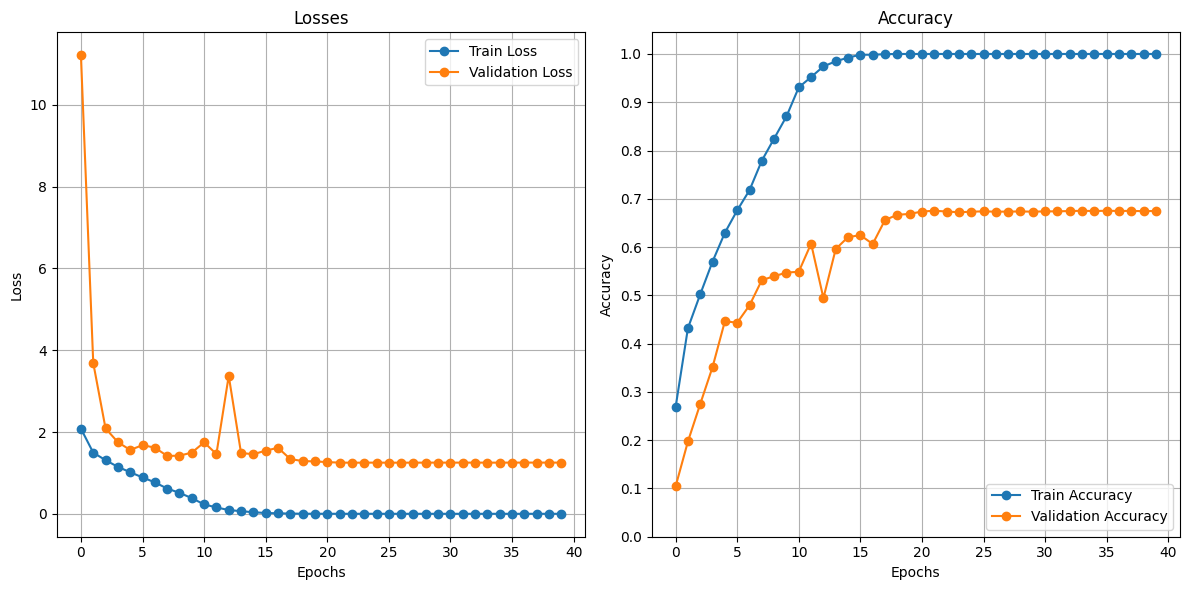

<module 'matplotlib.pyplot' from 'c:\\Users\\sever\\OneDrive\\Рабочий стол\\SSL\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def plot_results(results, name):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # График потерь
    axs[0].plot(results["train_losses"], label="Train Loss", marker='o')
    axs[0].plot(results["val_losses"], label="Validation Loss", marker='o')
    axs[0].set_title("Losses")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True)
    
    # График точности
    axs[1].plot(results["train_accs"], label="Train Accuracy", marker='o')
    axs[1].plot(results["val_accs"], label="Validation Accuracy", marker='o')
    axs[1].set_title("Accuracy")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_yticks(np.arange(0, 1.1, 0.1))
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.savefig(f'graphics/{name}_metrics')
    plt.show()
    return plt


plot_results(baseline_results, 'baseline')


## 1. Предсказание поворотов
(3 балла)

Вам необходимо обучить модель с нуля на предсказание угла поворота. В качестве обучающей и валидационной выборки используя `unlabeled`/`train` сплиты датасета STL10.

Определим допустимые повороты так - `[0, 90, 180, 270]` градусов, итого у нас 4 класса для задачи классификации (меняем `model.fc`), в которую мы превратили исходную. Теперь используя неразмеченную часть выборки (`split='unlabeled'`), необходимо сделать  из исходного датасета синтетический, который вместо пар (картинка, метка_класса) будет выдавать пары (картинка, метка_угла).
К примеру, можно определить новый класс `RotatedSTL10`, унаследовавшись от `VisionDataset`, а в нем реализовать случайный поворот на один из углов, и брать элементы так:

```python
def __getitem__(self, idx):
    img, _ = self.stl10_dataset[idx]
    img, angle = self.random_rotate(img)
    return img, angle
```

In [6]:
from torchvision.datasets import STL10
from torchvision.transforms import functional as F
from torch.utils.data import Dataset
import random

class RotatedSTL10(Dataset):
    def __init__(self, split, transform=None):
        self.stl10_dataset = STL10(root='./data', split=split, download=True)
        self.transform = transform
        self.angles = [0, 90, 180, 270]

    def random_rotate(self, img):
        angle = random.choice(self.angles)
        rotated_img = F.rotate(img, angle)
        label = self.angles.index(angle)
        return rotated_img, label

    def __getitem__(self, idx):
        img, _ = self.stl10_dataset[idx]
        if self.transform:
            img = self.transform(img)
        img, angle_label = self.random_rotate(img)
        return img, angle_label

    def __len__(self):
        return len(self.stl10_dataset)

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

unlabeled_rotated_dataset = RotatedSTL10(split='unlabeled', transform=transform)
train_rotated_dataset = RotatedSTL10(split='train', transform=transform)
# test_rotated_dataset = RotatedSTL10(split='train', transform=transform)

train_rotated_loader = DataLoader(unlabeled_rotated_dataset, batch_size=batch_size, shuffle=True)
val_rotated_loader = DataLoader(train_rotated_dataset, batch_size=batch_size, shuffle=False)
# test_rotated_loader = DataLoader(test_rotated_dataset, batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_rotated = models.resnet18(pretrained=False)
model_rotated.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_rotated.fc = nn.Linear(model_rotated.fc.in_features, 4)
model_rotated = model_rotated.to(device)

learning_rate = 0.001
num_epochs = 40
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_rotated.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
scaler = torch.amp.GradScaler()

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    print(f"Эпоха {epoch + 1}/{num_epochs}")
    train_loss, train_acc = train(model_rotated, train_rotated_loader, criterion, optimizer, scaler, device)
    val_loss, val_acc = validate(model_rotated, val_rotated_loader, criterion, device)

    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Потери на обучении: {train_loss:.4f}, Точность на обучении: {train_acc:.4f}")
    print(f"Потери на валидации: {val_loss:.4f}, Точность на валидации: {val_acc:.4f}")


rotated_results = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accs": train_accs,
    "val_accs": val_accs
}
torch.save(rotated_results, "rotated_results.pth")
torch.save(model_rotated.state_dict(), "rotated_weights.pth")

c:\Users\sever\OneDrive\Рабочий стол\SSL\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sever\OneDrive\Рабочий стол\SSL\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Эпоха 1/40


Потери на обучении: 0.9561, Точность на обучении: 0.6031
Потери на валидации: 0.7611, Точность на валидации: 0.6978
Эпоха 2/40


Потери на обучении: 0.6729, Точность на обучении: 0.7375
Потери на валидации: 0.6535, Точность на валидации: 0.7546
Эпоха 3/40


Потери на обучении: 0.5804, Точность на обучении: 0.7762
Потери на валидации: 0.6207, Точность на валидации: 0.7638
Эпоха 4/40


Потери на обучении: 0.5154, Точность на обучении: 0.8021
Потери на валидации: 0.6436, Точность на валидации: 0.7618
Эпоха 5/40


Потери на обучении: 0.4724, Точность на обучении: 0.8205
Потери на валидации: 0.4292, Точность на валидации: 0.8336
Эпоха 6/40


Потери на обучении: 0.4317, Точность на обучении: 0.8367
Потери на валидации: 0.4031, Точность на валидации: 0.8462
Эпоха 7/40


Потери на обучении: 0.4042, Точность на обучении: 0.8478
Потери на валидации: 0.3993, Точность на валидации: 0.8464
Эпоха 8/40


Потери на обучении: 0.3754, Точность на обучении: 0.8590
Потери на валидации: 0.3940, Точность на валидации: 0.8488
Эпоха 9/40


Потери на обучении: 0.3576, Точность на обучении: 0.8668
Потери на валидации: 0.4079, Точность на валидации: 0.8452
Эпоха 10/40


Потери на обучении: 0.3397, Точность на обучении: 0.8732
Потери на валидации: 0.6335, Точность на валидации: 0.8038
Эпоха 11/40


Потери на обучении: 0.3187, Точность на обучении: 0.8814
Потери на валидации: 0.3317, Точность на валидации: 0.8774
Эпоха 12/40


Потери на обучении: 0.3013, Точность на обучении: 0.8874
Потери на валидации: 0.3519, Точность на валидации: 0.8716
Эпоха 13/40


Потери на обучении: 0.2851, Точность на обучении: 0.8941
Потери на валидации: 0.2679, Точность на валидации: 0.9024
Эпоха 14/40


Потери на обучении: 0.2684, Точность на обучении: 0.9021
Потери на валидации: 0.2712, Точность на валидации: 0.8974
Эпоха 15/40


Потери на обучении: 0.2537, Точность на обучении: 0.9064
Потери на валидации: 0.2955, Точность на валидации: 0.8938
Эпоха 16/40


Потери на обучении: 0.2400, Точность на обучении: 0.9128
Потери на валидации: 0.2939, Точность на валидации: 0.8978
Эпоха 17/40


Потери на обучении: 0.2236, Точность на обучении: 0.9183
Потери на валидации: 0.3053, Точность на валидации: 0.8970
Эпоха 18/40


Потери на обучении: 0.2093, Точность на обучении: 0.9233
Потери на валидации: 0.2214, Точность на валидации: 0.9194
Эпоха 19/40


Потери на обучении: 0.1954, Точность на обучении: 0.9295
Потери на валидации: 0.2147, Точность на валидации: 0.9262
Эпоха 20/40


Потери на обучении: 0.1811, Точность на обучении: 0.9350
Потери на валидации: 0.2029, Точность на валидации: 0.9266
Эпоха 21/40


Потери на обучении: 0.1606, Точность на обучении: 0.9435
Потери на валидации: 0.1676, Точность на валидации: 0.9418
Эпоха 22/40


Потери на обучении: 0.1490, Точность на обучении: 0.9472
Потери на валидации: 0.1729, Точность на валидации: 0.9424
Эпоха 23/40


Потери на обучении: 0.1345, Точность на обучении: 0.9526
Потери на валидации: 0.1199, Точность на валидации: 0.9580
Эпоха 24/40


Потери на обучении: 0.1207, Точность на обучении: 0.9581
Потери на валидации: 0.1131, Точность на валидации: 0.9600
Эпоха 25/40


Потери на обучении: 0.1063, Точность на обучении: 0.9633
Потери на валидации: 0.0954, Точность на валидации: 0.9686
Эпоха 26/40


Потери на обучении: 0.0931, Точность на обучении: 0.9690
Потери на валидации: 0.1638, Точность на валидации: 0.9462
Эпоха 27/40


Потери на обучении: 0.0805, Точность на обучении: 0.9738
Потери на валидации: 0.0902, Точность на валидации: 0.9690
Эпоха 28/40


Потери на обучении: 0.0682, Точность на обучении: 0.9775
Потери на валидации: 0.0758, Точность на валидации: 0.9754
Эпоха 29/40


Потери на обучении: 0.0573, Точность на обучении: 0.9819
Потери на валидации: 0.0742, Точность на валидации: 0.9780
Эпоха 30/40


Потери на обучении: 0.0484, Точность на обучении: 0.9851
Потери на валидации: 0.0600, Точность на валидации: 0.9830
Эпоха 31/40


Потери на обучении: 0.0390, Точность на обучении: 0.9881
Потери на валидации: 0.0582, Точность на валидации: 0.9854
Эпоха 32/40


Потери на обучении: 0.0320, Точность на обучении: 0.9909
Потери на валидации: 0.0553, Точность на валидации: 0.9856
Эпоха 33/40


Потери на обучении: 0.0257, Точность на обучении: 0.9931
Потери на валидации: 0.0510, Точность на валидации: 0.9880
Эпоха 34/40


Потери на обучении: 0.0210, Точность на обучении: 0.9941
Потери на валидации: 0.0486, Точность на валидации: 0.9896
Эпоха 35/40


Потери на обучении: 0.0180, Точность на обучении: 0.9956
Потери на валидации: 0.0453, Точность на валидации: 0.9914
Эпоха 36/40


Потери на обучении: 0.0158, Точность на обучении: 0.9961
Потери на валидации: 0.0446, Точность на валидации: 0.9916
Эпоха 37/40


Потери на обучении: 0.0131, Точность на обучении: 0.9971
Потери на валидации: 0.0447, Точность на валидации: 0.9904
Эпоха 38/40


Потери на обучении: 0.0119, Точность на обучении: 0.9974
Потери на валидации: 0.0437, Точность на валидации: 0.9900
Эпоха 39/40


Потери на обучении: 0.0115, Точность на обучении: 0.9975
Потери на валидации: 0.0412, Точность на валидации: 0.9916
Эпоха 40/40


Потери на обучении: 0.0106, Точность на обучении: 0.9979
Потери на валидации: 0.0440, Точность на валидации: 0.9914


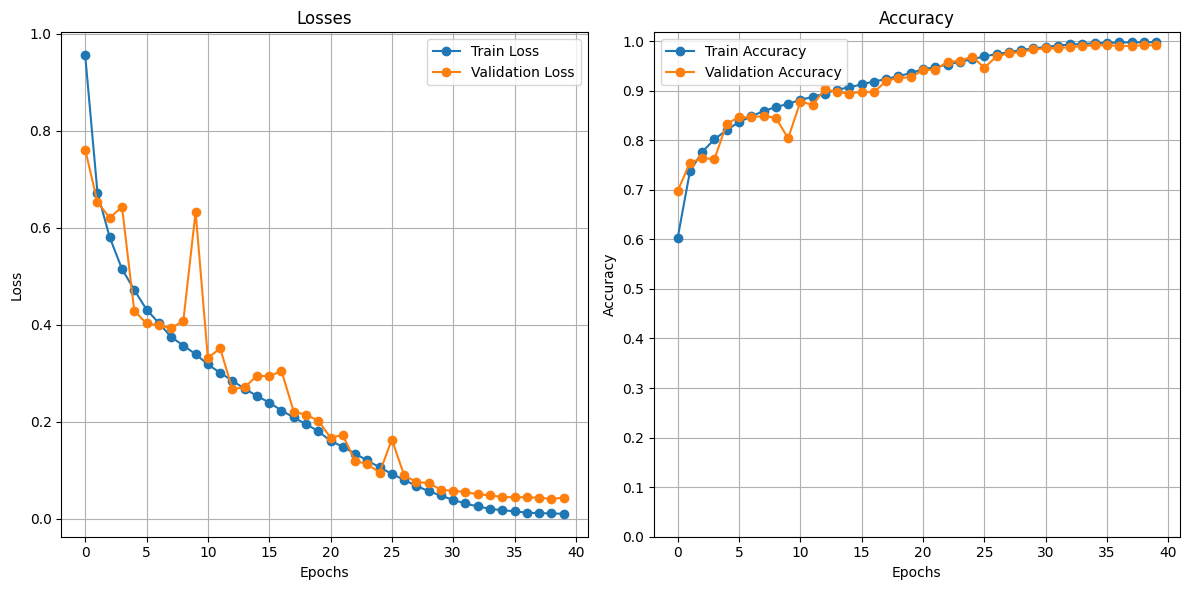

<module 'matplotlib.pyplot' from 'c:\\Users\\sever\\OneDrive\\Рабочий стол\\SSL\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [9]:
plot_results(rotated_results, 'rotated')

## 2. t-SNE
(1 балл)

Визуализируйте полученные векторные представления для `train` и `test` сплитов, используя t-SNE (`sklearn.manifold.TSNE`). Для этого необходимо брать репрезентации (`model.avgpool`), а также покрасить точки по классам (у каждого класса свой цвет). Хорошо ли разделяются исходные 10 классов?



In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import torch

model_rotated.eval()

train_features, train_labels = [], []
test_features, test_labels = [], []

def extract_features(loader, model, device):
    features, labels = [], []
    with torch.no_grad():
        for images, lbls in loader:
            images = images.to(device)
            lbls = lbls.to(device)
            
            # Извлечение представлений из слоя avgpool
            output = model.avgpool(images)
            output = output.view(output.size(0), -1) 
            features.append(output.cpu().numpy())
            labels.append(lbls.cpu().numpy())
    return np.concatenate(features, axis=0), np.concatenate(labels, axis=0)


train_features, train_labels = extract_features(train_loader, model_rotated, device)
test_features, test_labels = extract_features(test_loader, model_rotated, device)


C:\Users\sever\AppData\Local\Temp\ipykernel_27548\754827654.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


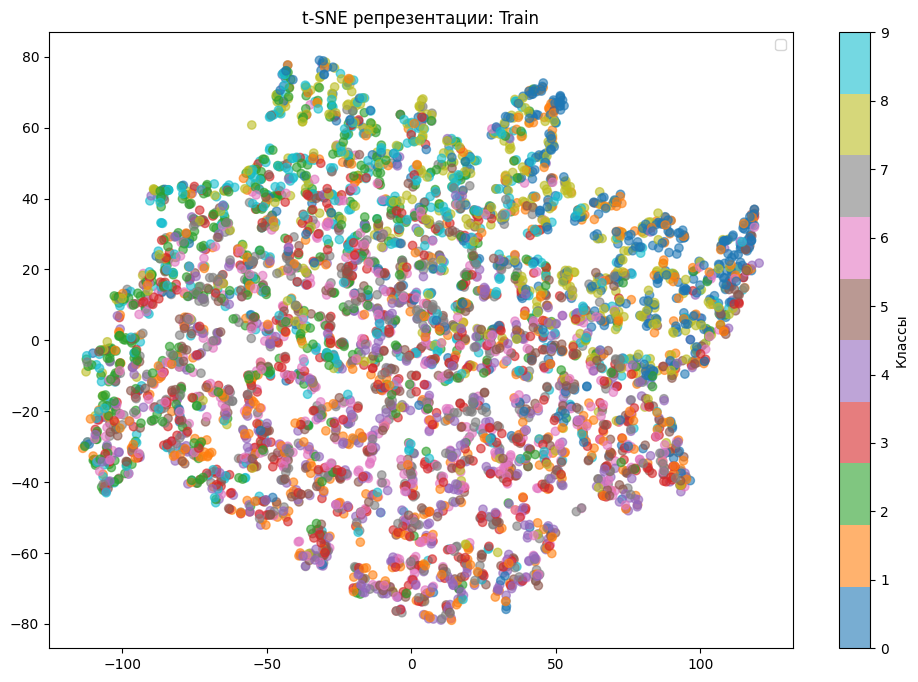

In [23]:
features = np.concatenate([train_features, test_features], axis=0)
labels = np.concatenate([train_labels, test_labels], axis=0)


tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(features)

tsne_train = tsne_results[:len(train_features)]
tsne_test = tsne_results[len(train_features):]

plt.figure(figsize=(12, 8))
scatter_train = plt.scatter(tsne_train[:, 0], tsne_train[:, 1], c=train_labels, cmap='tab10', alpha=0.6)
plt.colorbar(scatter_train, label='Классы')
plt.title('t-SNE репрезентации: Train')
plt.legend()
plt.savefig('graphics/tsne_train')
plt.show()


C:\Users\sever\AppData\Local\Temp\ipykernel_27548\3707328149.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


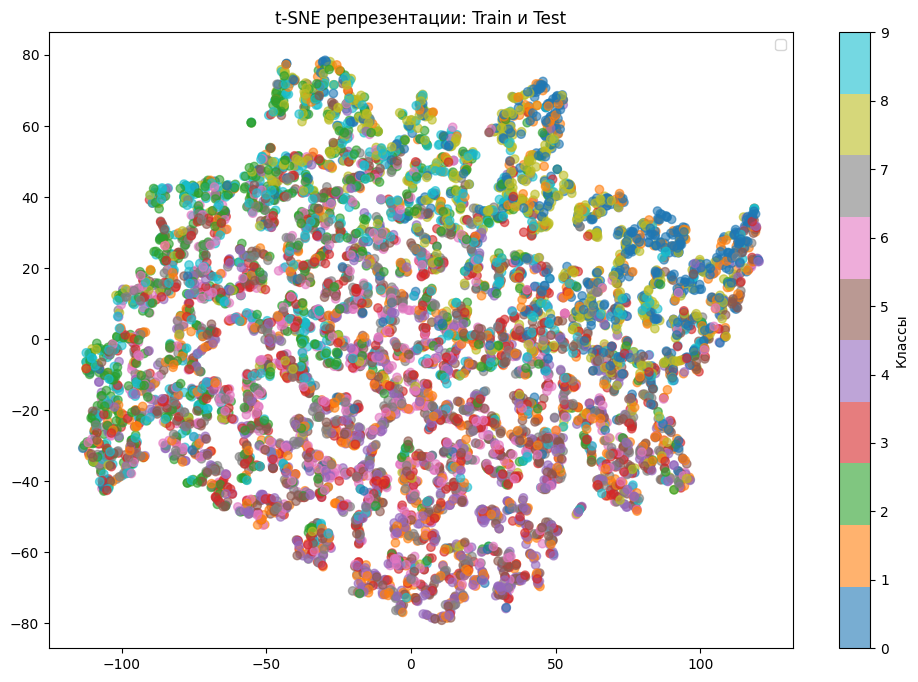

In [12]:
plt.figure(figsize=(12, 8))
scatter_test = plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=test_labels, cmap='tab10', alpha=0.6)
plt.colorbar(scatter_test, label='Классы')
plt.title('t-SNE репрезентации: Train и Test')
plt.legend()
plt.savefig('graphics/tsne_test')
plt.show()


## 3. Линейный пробинг
(1.5 балла)

Для того, чтобы сделать линейный пробинг предобученной модели, необходимо последний слой (`model.fc`) поменять на новый, подходящий под конечную задачу ('линейную пробу'). В этом случае &mdash; на родную для STL10 классификацию на 10 исходных классов. Заморозьте энкодер и обучите только добавленный слой на `train` сплите, провалидируйте на `test` сплите. Какого лучшего качества вам удалось добиться? Насколько оно лучше бейзлайна (обучения с учителем из случайной инициализации энкодера из пункта 0)? Сравните графики функции потерь бейзлайна и обучения линейной пробы.



In [26]:
from torchvision import models
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_rotated_update_fc = models.resnet18(pretrained=False)
model_rotated_update_fc.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_rotated_update_fc.fc = nn.Linear(model_rotated_update_fc.fc.in_features, 4)
model_rotated_update_fc = model_rotated_update_fc.to(device)

model_rotated_update_fc = copy.deepcopy(model_rotated)
model_rotated_update_fc = model_rotated_update_fc.to(device)


In [27]:
# Замораживаем все слои модели (кроме последнего)
for param in model_rotated_update_fc.parameters():
    param.requires_grad = False

model_rotated_update_fc.fc = nn.Linear(model_rotated_update_fc.fc.in_features, 10)
model_rotated_update_fc = model_rotated_update_fc.to(device)

learning_rate = 0.001
num_epochs = 40

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_rotated_update_fc.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
scaler = torch.amp.GradScaler()

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in tqdm(range(num_epochs)):
    print(f"Эпоха {epoch + 1}/{num_epochs}")
    train_loss, train_acc = train(model_rotated_update_fc, train_loader, criterion, optimizer, scaler, device)
    val_loss, val_acc = validate(model_rotated_update_fc, test_loader, criterion, device)

    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Потери на обучении: {train_loss:.4f}, Точность на обучении: {train_acc:.4f}")
    print(f"Потери на валидации: {val_loss:.4f}, Точность на валидации: {val_acc:.4f}")

results_updated_fc = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accs": train_accs,
    "val_accs": val_accs
}
torch.save(results_updated_fc, "rotated_updated_fc_results.pth")
torch.save(model_rotated_update_fc.state_dict(), "rotated_updated_fc_weights.pth")

  0%|          | 0/40 [00:00<?, ?it/s]

Эпоха 1/40


  2%|▎         | 1/40 [00:02<01:52,  2.87s/it]

Потери на обучении: 2.2280, Точность на обучении: 0.1712
Потери на валидации: 2.1917, Точность на валидации: 0.1624
Эпоха 2/40


  5%|▌         | 2/40 [00:05<01:40,  2.64s/it]

Потери на обучении: 2.0834, Точность на обучении: 0.2386
Потери на валидации: 2.0578, Точность на валидации: 0.2586
Эпоха 3/40


  8%|▊         | 3/40 [00:07<01:36,  2.60s/it]

Потери на обучении: 1.9982, Точность на обучении: 0.2882
Потери на валидации: 1.9660, Точность на валидации: 0.3111
Эпоха 4/40


 10%|█         | 4/40 [00:10<01:31,  2.54s/it]

Потери на обучении: 1.9239, Точность на обучении: 0.3314
Потери на валидации: 1.8980, Точность на валидации: 0.3563
Эпоха 5/40


 12%|█▎        | 5/40 [00:12<01:28,  2.52s/it]

Потери на обучении: 1.8590, Точность на обучении: 0.3708
Потери на валидации: 1.8519, Точность на валидации: 0.3636
Эпоха 6/40


 15%|█▌        | 6/40 [00:15<01:25,  2.51s/it]

Потери на обучении: 1.8121, Точность на обучении: 0.3788
Потери на валидации: 1.7998, Точность на валидации: 0.3885
Эпоха 7/40


 18%|█▊        | 7/40 [00:17<01:21,  2.48s/it]

Потери на обучении: 1.7655, Точность на обучении: 0.4046
Потери на валидации: 1.7577, Точность на валидации: 0.4123
Эпоха 8/40


 20%|██        | 8/40 [00:20<01:19,  2.48s/it]

Потери на обучении: 1.7246, Точность на обучении: 0.4236
Потери на валидации: 1.7264, Точность на валидации: 0.4200
Эпоха 9/40


 22%|██▎       | 9/40 [00:22<01:16,  2.48s/it]

Потери на обучении: 1.6909, Точность на обучении: 0.4336
Потери на валидации: 1.6923, Точность на валидации: 0.4231
Эпоха 10/40


 25%|██▌       | 10/40 [00:25<01:13,  2.46s/it]

Потери на обучении: 1.6629, Точность на обучении: 0.4396
Потери на валидации: 1.6686, Точность на валидации: 0.4399
Эпоха 11/40


 28%|██▊       | 11/40 [00:27<01:11,  2.46s/it]

Потери на обучении: 1.6367, Точность на обучении: 0.4538
Потери на валидации: 1.6429, Точность на валидации: 0.4455
Эпоха 12/40


 30%|███       | 12/40 [00:30<01:08,  2.45s/it]

Потери на обучении: 1.6119, Точность на обучении: 0.4630
Потери на валидации: 1.6194, Точность на валидации: 0.4626
Эпоха 13/40


 32%|███▎      | 13/40 [00:32<01:06,  2.46s/it]

Потери на обучении: 1.5926, Точность на обучении: 0.4726
Потери на валидации: 1.6013, Точность на валидации: 0.4554
Эпоха 14/40


 35%|███▌      | 14/40 [00:34<01:03,  2.45s/it]

Потери на обучении: 1.5738, Точность на обучении: 0.4736
Потери на валидации: 1.5845, Точность на валидации: 0.4695
Эпоха 15/40


 38%|███▊      | 15/40 [00:37<01:01,  2.45s/it]

Потери на обучении: 1.5579, Точность на обучении: 0.4812
Потери на валидации: 1.5718, Точность на валидации: 0.4665
Эпоха 16/40


 40%|████      | 16/40 [00:39<00:59,  2.48s/it]

Потери на обучении: 1.5455, Точность на обучении: 0.4816
Потери на валидации: 1.5565, Точность на валидации: 0.4794
Эпоха 17/40


 42%|████▎     | 17/40 [00:42<00:56,  2.46s/it]

Потери на обучении: 1.5315, Точность на обучении: 0.4794
Потери на валидации: 1.5444, Точность на валидации: 0.4760
Эпоха 18/40


 45%|████▌     | 18/40 [00:44<00:53,  2.45s/it]

Потери на обучении: 1.5164, Точность на обучении: 0.4856
Потери на валидации: 1.5340, Точность на валидации: 0.4861
Эпоха 19/40


 48%|████▊     | 19/40 [00:47<00:51,  2.46s/it]

Потери на обучении: 1.5086, Точность на обучении: 0.4924
Потери на валидации: 1.5239, Точность на валидации: 0.4811
Эпоха 20/40


 50%|█████     | 20/40 [00:49<00:49,  2.45s/it]

Потери на обучении: 1.4942, Точность на обучении: 0.4988
Потери на валидации: 1.5146, Точность на валидации: 0.4921
Эпоха 21/40


 52%|█████▎    | 21/40 [00:52<00:46,  2.46s/it]

Потери на обучении: 1.4852, Точность на обучении: 0.5032
Потери на валидации: 1.5054, Точность на валидации: 0.4896
Эпоха 22/40


 55%|█████▌    | 22/40 [00:54<00:43,  2.44s/it]

Потери на обучении: 1.4774, Точность на обучении: 0.5040
Потери на валидации: 1.4989, Точность на валидации: 0.4943
Эпоха 23/40


 57%|█████▊    | 23/40 [00:57<00:41,  2.45s/it]

Потери на обучении: 1.4711, Точность на обучении: 0.5036
Потери на валидации: 1.4934, Точность на валидации: 0.4948
Эпоха 24/40


 60%|██████    | 24/40 [00:59<00:39,  2.44s/it]

Потери на обучении: 1.4659, Точность на обучении: 0.5092
Потери на валидации: 1.4874, Точность на валидации: 0.4985
Эпоха 25/40


 62%|██████▎   | 25/40 [01:01<00:36,  2.45s/it]

Потери на обучении: 1.4571, Точность на обучении: 0.5084
Потери на валидации: 1.4832, Точность на валидации: 0.4978
Эпоха 26/40


 65%|██████▌   | 26/40 [01:04<00:34,  2.46s/it]

Потери на обучении: 1.4524, Точность на обучении: 0.5164
Потери на валидации: 1.4789, Точность на валидации: 0.4991
Эпоха 27/40


 68%|██████▊   | 27/40 [01:06<00:32,  2.47s/it]

Потери на обучении: 1.4492, Точность на обучении: 0.5136
Потери на валидации: 1.4746, Точность на валидации: 0.5022
Эпоха 28/40


 70%|███████   | 28/40 [01:09<00:29,  2.45s/it]

Потери на обучении: 1.4452, Точность на обучении: 0.5118
Потери на валидации: 1.4713, Точность на валидации: 0.5002
Эпоха 29/40


 72%|███████▎  | 29/40 [01:11<00:27,  2.46s/it]

Потери на обучении: 1.4420, Точность на обучении: 0.5162
Потери на валидации: 1.4686, Точность на валидации: 0.5014
Эпоха 30/40


 75%|███████▌  | 30/40 [01:14<00:24,  2.46s/it]

Потери на обучении: 1.4373, Точность на обучении: 0.5172
Потери на валидации: 1.4659, Точность на валидации: 0.5054
Эпоха 31/40


 78%|███████▊  | 31/40 [01:16<00:22,  2.48s/it]

Потери на обучении: 1.4359, Точность на обучении: 0.5166
Потери на валидации: 1.4641, Точность на валидации: 0.5042
Эпоха 32/40


 80%|████████  | 32/40 [01:19<00:19,  2.48s/it]

Потери на обучении: 1.4332, Точность на обучении: 0.5208
Потери на валидации: 1.4621, Точность на валидации: 0.5024
Эпоха 33/40


 82%|████████▎ | 33/40 [01:21<00:17,  2.49s/it]

Потери на обучении: 1.4321, Точность на обучении: 0.5194
Потери на валидации: 1.4612, Точность на валидации: 0.5034
Эпоха 34/40


 85%|████████▌ | 34/40 [01:24<00:14,  2.47s/it]

Потери на обучении: 1.4304, Точность на обучении: 0.5158
Потери на валидации: 1.4603, Точность на валидации: 0.5046
Эпоха 35/40


 88%|████████▊ | 35/40 [01:26<00:12,  2.49s/it]

Потери на обучении: 1.4299, Точность на обучении: 0.5168
Потери на валидации: 1.4595, Точность на валидации: 0.5060
Эпоха 36/40


 90%|█████████ | 36/40 [01:29<00:09,  2.49s/it]

Потери на обучении: 1.4304, Точность на обучении: 0.5220
Потери на валидации: 1.4589, Точность на валидации: 0.5049
Эпоха 37/40


 92%|█████████▎| 37/40 [01:31<00:07,  2.49s/it]

Потери на обучении: 1.4293, Точность на обучении: 0.5204
Потери на валидации: 1.4587, Точность на валидации: 0.5049
Эпоха 38/40


 95%|█████████▌| 38/40 [01:34<00:04,  2.47s/it]

Потери на обучении: 1.4292, Точность на обучении: 0.5218
Потери на валидации: 1.4585, Точность на валидации: 0.5051
Эпоха 39/40


 98%|█████████▊| 39/40 [01:36<00:02,  2.47s/it]

Потери на обучении: 1.4291, Точность на обучении: 0.5198
Потери на валидации: 1.4582, Точность на валидации: 0.5055
Эпоха 40/40


100%|██████████| 40/40 [01:39<00:00,  2.48s/it]

Потери на обучении: 1.4284, Точность на обучении: 0.5204
Потери на валидации: 1.4584, Точность на валидации: 0.5055


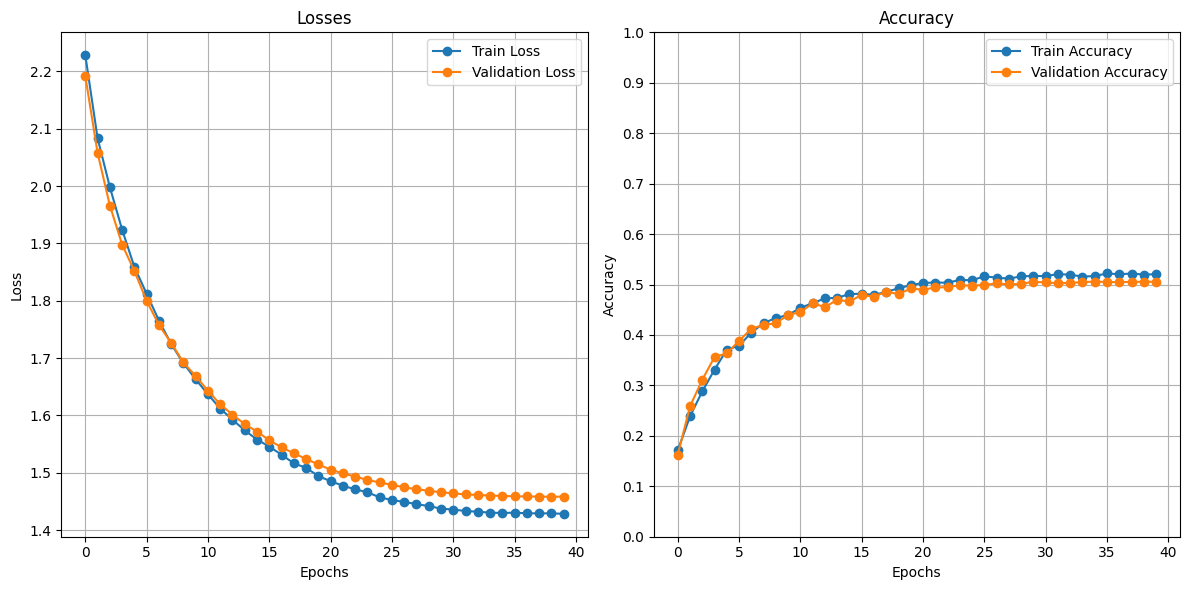

<module 'matplotlib.pyplot' from 'c:\\Users\\sever\\OneDrive\\Рабочий стол\\SSL\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [28]:
plot_results(results_updated_fc, 'updated_fc')


## 4. Fine-tuning
(1.5 балла)

Попробуйте дообучить всю сеть полученную в пункте 1. Можно ли предложить более эффективную схему для файнтьюна? Какое качество вам удалось добиться здесь? Снова визуализируйте репрезентации с помощью t-SNE (как в пункте 2) и проанализируйте изменения.



In [19]:
from torchvision import models
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_rotated_update_all = models.resnet18(pretrained=False)
model_rotated_update_all.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_rotated_update_all.fc = nn.Linear(model_rotated_update_all.fc.in_features, 4)
model_rotated_update_all = model_rotated_update_all.to(device)

model_rotated_update_all = copy.deepcopy(model_rotated)
model_rotated_update_all = model_rotated_update_all.to(device)


c:\Users\sever\OneDrive\Рабочий стол\SSL\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sever\OneDrive\Рабочий стол\SSL\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [20]:
# Размораживаем все слои модели
for param in model_rotated_update_all.parameters():
    param.requires_grad = True

model_rotated_update_all.fc = nn.Linear(model_rotated_update_all.fc.in_features, 10)
model_rotated_update_all = model_rotated_update_all.to(device)


learning_rate = 0.001
num_epochs = 40

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_rotated_update_all.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
scaler = torch.amp.GradScaler()

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in tqdm(range(num_epochs)):
    print(f"Эпоха {epoch + 1}/{num_epochs}")
    train_loss, train_acc = train(model_rotated_update_all, train_loader, criterion, optimizer, scaler, device)
    val_loss, val_acc = validate(model_rotated_update_all, test_loader, criterion, device)

    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Потери на обучении: {train_loss:.4f}, Точность на обучении: {train_acc:.4f}")
    print(f"Потери на валидации: {val_loss:.4f}, Точность на валидации: {val_acc:.4f}")

results_updated_all = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accs": train_accs,
    "val_accs": val_accs
}
torch.save(results_updated_all, "rotated_updated_all_results.pth")
torch.save(model_rotated_update_all.state_dict(), "rotated_updated_all_weights.pth")

  0%|          | 0/40 [00:00<?, ?it/s]

Эпоха 1/40


  2%|▎         | 1/40 [00:03<02:11,  3.36s/it]

Потери на обучении: 1.5430, Точность на обучении: 0.4636
Потери на валидации: 2.3588, Точность на валидации: 0.4049
Эпоха 2/40


  5%|▌         | 2/40 [00:06<02:00,  3.17s/it]

Потери на обучении: 0.7693, Точность на обучении: 0.7320
Потери на валидации: 1.3243, Точность на валидации: 0.5975
Эпоха 3/40


  8%|▊         | 3/40 [00:09<01:55,  3.11s/it]

Потери на обучении: 0.4532, Точность на обучении: 0.8480
Потери на валидации: 1.1373, Точность на валидации: 0.6119
Эпоха 4/40


 10%|█         | 4/40 [00:12<01:51,  3.08s/it]

Потери на обучении: 0.2236, Точность на обучении: 0.9416
Потери на валидации: 1.0396, Точность на валидации: 0.6575
Эпоха 5/40


 12%|█▎        | 5/40 [00:15<01:47,  3.06s/it]

Потери на обучении: 0.0876, Точность на обучении: 0.9868
Потери на валидации: 1.0305, Точность на валидации: 0.6769
Эпоха 6/40


 15%|█▌        | 6/40 [00:18<01:43,  3.05s/it]

Потери на обучении: 0.0321, Точность на обучении: 0.9976
Потери на валидации: 0.9682, Точность на валидации: 0.7084
Эпоха 7/40


 18%|█▊        | 7/40 [00:21<01:40,  3.04s/it]

Потери на обучении: 0.0168, Точность на обучении: 0.9984
Потери на валидации: 0.7690, Точность на валидации: 0.7594
Эпоха 8/40


 20%|██        | 8/40 [00:24<01:37,  3.03s/it]

Потери на обучении: 0.0076, Точность на обучении: 0.9998
Потери на валидации: 0.7767, Точность на валидации: 0.7679
Эпоха 9/40


 22%|██▎       | 9/40 [00:27<01:34,  3.04s/it]

Потери на обучении: 0.0039, Точность на обучении: 1.0000
Потери на валидации: 0.7693, Точность на валидации: 0.7810
Эпоха 10/40


 25%|██▌       | 10/40 [00:30<01:30,  3.03s/it]

Потери на обучении: 0.0025, Точность на обучении: 1.0000
Потери на валидации: 0.7197, Точность на валидации: 0.7890
Эпоха 11/40


 28%|██▊       | 11/40 [00:33<01:28,  3.04s/it]

Потери на обучении: 0.0019, Точность на обучении: 1.0000
Потери на валидации: 0.7283, Точность на валидации: 0.7850
Эпоха 12/40


 30%|███       | 12/40 [00:36<01:25,  3.04s/it]

Потери на обучении: 0.0015, Точность на обучении: 1.0000
Потери на валидации: 0.7213, Точность на валидации: 0.7889
Эпоха 13/40


 32%|███▎      | 13/40 [00:39<01:22,  3.04s/it]

Потери на обучении: 0.0013, Точность на обучении: 1.0000
Потери на валидации: 0.7288, Точность на валидации: 0.7895
Эпоха 14/40


 35%|███▌      | 14/40 [00:42<01:18,  3.04s/it]

Потери на обучении: 0.0012, Точность на обучении: 1.0000
Потери на валидации: 0.7281, Точность на валидации: 0.7895
Эпоха 15/40


 38%|███▊      | 15/40 [00:45<01:15,  3.04s/it]

Потери на обучении: 0.0011, Точность на обучении: 1.0000
Потери на валидации: 0.7296, Точность на валидации: 0.7900
Эпоха 16/40


 40%|████      | 16/40 [00:48<01:12,  3.03s/it]

Потери на обучении: 0.0010, Точность на обучении: 1.0000
Потери на валидации: 0.7323, Точность на валидации: 0.7904
Эпоха 17/40


 42%|████▎     | 17/40 [00:51<01:09,  3.03s/it]

Потери на обучении: 0.0009, Точность на обучении: 1.0000
Потери на валидации: 0.7334, Точность на валидации: 0.7909
Эпоха 18/40


 45%|████▌     | 18/40 [00:54<01:06,  3.03s/it]

Потери на обучении: 0.0009, Точность на обучении: 1.0000
Потери на валидации: 0.7374, Точность на валидации: 0.7887
Эпоха 19/40


 48%|████▊     | 19/40 [00:57<01:03,  3.02s/it]

Потери на обучении: 0.0008, Точность на обучении: 1.0000
Потери на валидации: 0.7387, Точность на валидации: 0.7903
Эпоха 20/40


 50%|█████     | 20/40 [01:00<01:00,  3.03s/it]

Потери на обучении: 0.0008, Точность на обучении: 1.0000
Потери на валидации: 0.7394, Точность на валидации: 0.7911
Эпоха 21/40


 52%|█████▎    | 21/40 [01:03<00:57,  3.02s/it]

Потери на обучении: 0.0008, Точность на обучении: 1.0000
Потери на валидации: 0.7434, Точность на валидации: 0.7904
Эпоха 22/40


 55%|█████▌    | 22/40 [01:06<00:54,  3.02s/it]

Потери на обучении: 0.0007, Точность на обучении: 1.0000
Потери на валидации: 0.7429, Точность на валидации: 0.7900
Эпоха 23/40


 57%|█████▊    | 23/40 [01:10<00:51,  3.02s/it]

Потери на обучении: 0.0007, Точность на обучении: 1.0000
Потери на валидации: 0.7430, Точность на валидации: 0.7900
Эпоха 24/40


 60%|██████    | 24/40 [01:13<00:48,  3.03s/it]

Потери на обучении: 0.0007, Точность на обучении: 1.0000
Потери на валидации: 0.7471, Точность на валидации: 0.7900
Эпоха 25/40


 62%|██████▎   | 25/40 [01:16<00:45,  3.05s/it]

Потери на обучении: 0.0006, Точность на обучении: 1.0000
Потери на валидации: 0.7471, Точность на валидации: 0.7904
Эпоха 26/40


 65%|██████▌   | 26/40 [01:19<00:42,  3.04s/it]

Потери на обучении: 0.0007, Точность на обучении: 1.0000
Потери на валидации: 0.7478, Точность на валидации: 0.7903
Эпоха 27/40


 68%|██████▊   | 27/40 [01:22<00:39,  3.04s/it]

Потери на обучении: 0.0006, Точность на обучении: 1.0000
Потери на валидации: 0.7488, Точность на валидации: 0.7910
Эпоха 28/40


 70%|███████   | 28/40 [01:25<00:36,  3.04s/it]

Потери на обучении: 0.0006, Точность на обучении: 1.0000
Потери на валидации: 0.7500, Точность на валидации: 0.7911
Эпоха 29/40


 72%|███████▎  | 29/40 [01:28<00:33,  3.03s/it]

Потери на обучении: 0.0006, Точность на обучении: 1.0000
Потери на валидации: 0.7496, Точность на валидации: 0.7897
Эпоха 30/40


 75%|███████▌  | 30/40 [01:31<00:30,  3.03s/it]

Потери на обучении: 0.0006, Точность на обучении: 1.0000
Потери на валидации: 0.7504, Точность на валидации: 0.7901
Эпоха 31/40


 78%|███████▊  | 31/40 [01:34<00:27,  3.03s/it]

Потери на обучении: 0.0006, Точность на обучении: 1.0000
Потери на валидации: 0.7507, Точность на валидации: 0.7897
Эпоха 32/40


 80%|████████  | 32/40 [01:37<00:24,  3.03s/it]

Потери на обучении: 0.0006, Точность на обучении: 1.0000
Потери на валидации: 0.7511, Точность на валидации: 0.7905
Эпоха 33/40


 82%|████████▎ | 33/40 [01:40<00:21,  3.03s/it]

Потери на обучении: 0.0005, Точность на обучении: 1.0000
Потери на валидации: 0.7518, Точность на валидации: 0.7905
Эпоха 34/40


 85%|████████▌ | 34/40 [01:43<00:18,  3.03s/it]

Потери на обучении: 0.0006, Точность на обучении: 1.0000
Потери на валидации: 0.7524, Точность на валидации: 0.7904
Эпоха 35/40


 88%|████████▊ | 35/40 [01:46<00:15,  3.03s/it]

Потери на обучении: 0.0005, Точность на обучении: 1.0000
Потери на валидации: 0.7525, Точность на валидации: 0.7904
Эпоха 36/40


 90%|█████████ | 36/40 [01:49<00:12,  3.03s/it]

Потери на обучении: 0.0005, Точность на обучении: 1.0000
Потери на валидации: 0.7516, Точность на валидации: 0.7903
Эпоха 37/40


 92%|█████████▎| 37/40 [01:52<00:09,  3.03s/it]

Потери на обучении: 0.0005, Точность на обучении: 1.0000
Потери на валидации: 0.7524, Точность на валидации: 0.7900
Эпоха 38/40


 95%|█████████▌| 38/40 [01:55<00:06,  3.03s/it]

Потери на обучении: 0.0005, Точность на обучении: 1.0000
Потери на валидации: 0.7528, Точность на валидации: 0.7903
Эпоха 39/40


 98%|█████████▊| 39/40 [01:58<00:03,  3.03s/it]

Потери на обучении: 0.0005, Точность на обучении: 1.0000
Потери на валидации: 0.7522, Точность на валидации: 0.7897
Эпоха 40/40


100%|██████████| 40/40 [02:01<00:00,  3.04s/it]

Потери на обучении: 0.0005, Точность на обучении: 1.0000
Потери на валидации: 0.7527, Точность на валидации: 0.7907


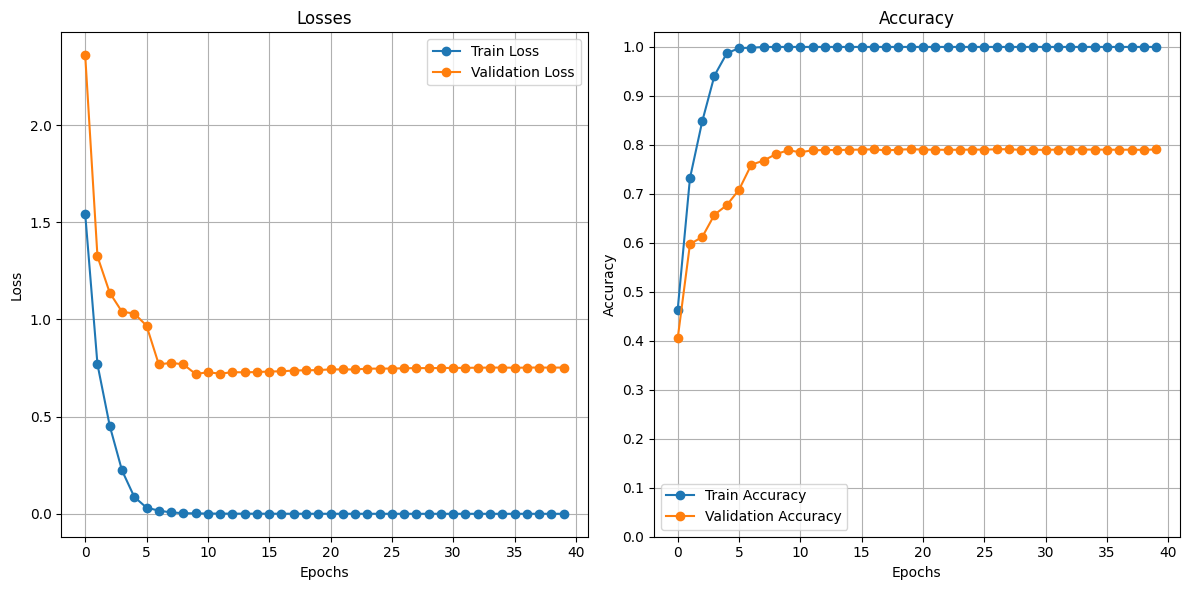

<module 'matplotlib.pyplot' from 'c:\\Users\\sever\\OneDrive\\Рабочий стол\\SSL\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [21]:
plot_results(results_updated_all, 'updated_all')

c:\Users\sever\OneDrive\Рабочий стол\SSL\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\sever\OneDrive\Рабочий стол\SSL\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
C:\Users\sever\AppData\Local\Temp\ipykernel_18216\3601210116.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


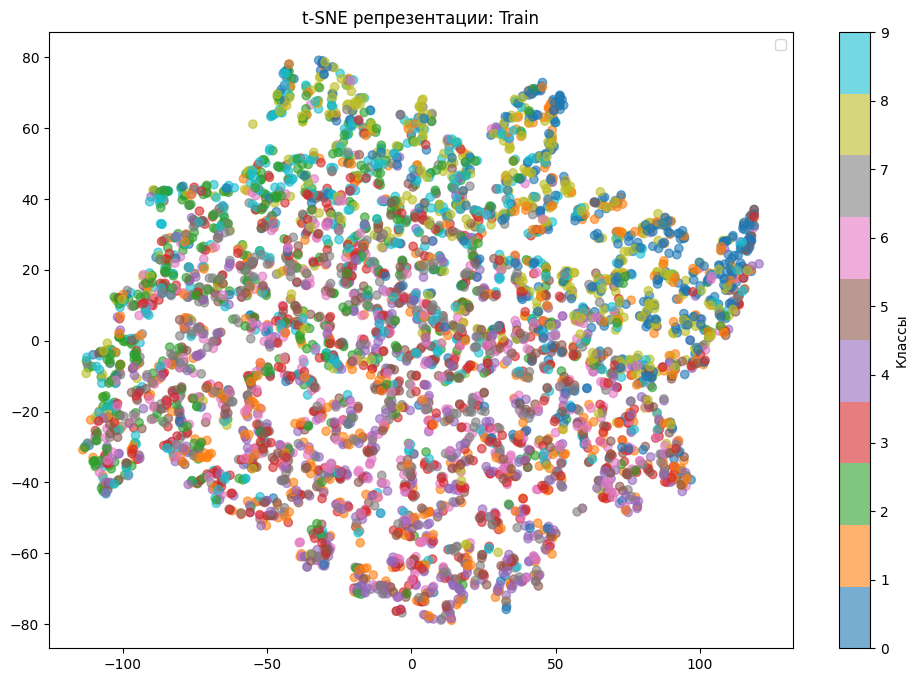

In [24]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import torch

model_rotated_update_all.eval()

train_features, train_labels = [], []
test_features, test_labels = [], []



train_features, train_labels = extract_features(train_loader, model_rotated_update_all, device)
test_features, test_labels = extract_features(test_loader, model_rotated_update_all, device)

features = np.concatenate([train_features, test_features], axis=0)
labels = np.concatenate([train_labels, test_labels], axis=0)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(features)

tsne_train = tsne_results[:len(train_features)]
tsne_test = tsne_results[len(train_features):]

plt.figure(figsize=(12, 8))
scatter_train = plt.scatter(tsne_train[:, 0], tsne_train[:, 1], c=train_labels, cmap='tab10', alpha=0.6)
plt.colorbar(scatter_train, label='Классы')
plt.title('t-SNE репрезентации: Train')
plt.legend()
plt.savefig('graphics/tsne_train_fine_tuned')
plt.show()



C:\Users\sever\AppData\Local\Temp\ipykernel_18216\2540925632.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


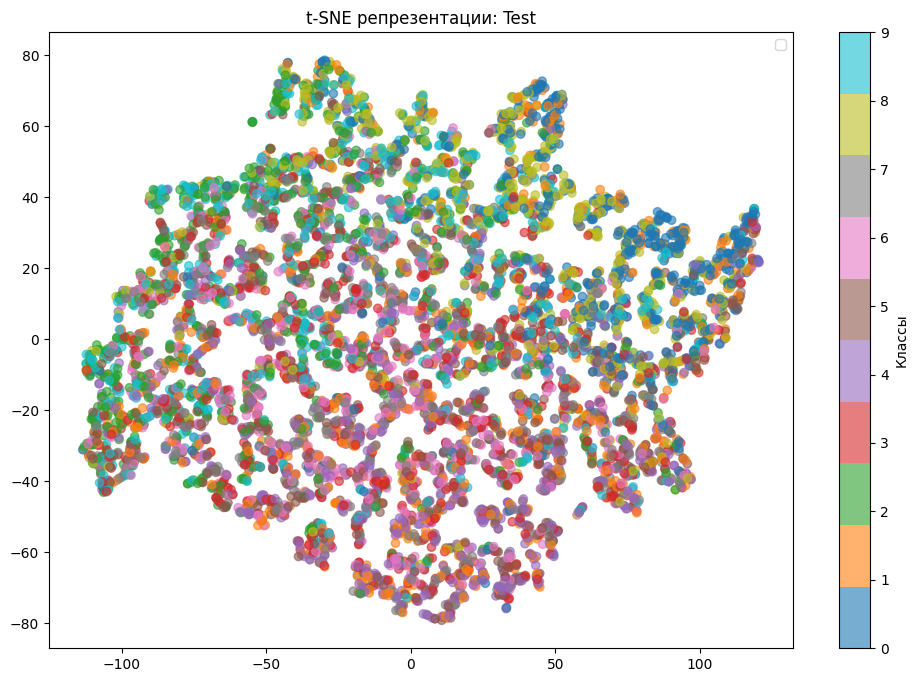

In [25]:
plt.figure(figsize=(12, 8))
scatter_test = plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c=test_labels, cmap='tab10', alpha=0.6)
plt.colorbar(scatter_test, label='Классы')
plt.title('t-SNE репрезентации: Test')
plt.legend()
plt.savefig('graphics/tsne_test_fine_tuned')
plt.show()


### Можно ли предложить более эффективную схему для файнтьюна?

Да, можно. Например, Двухэтапный Fine-Tuning: 

Сначала замораживаем все слои, кроме классификатора, и обучаем только классификатор. Затем размораживаем энкодер и обучаем всю модель. 

На первом этапе модель сосредотачивается на адаптации классификатора к новым данным, что стабилизирует начальные шаги обучения. Разморозка энкодера на втором этапе позволяет извлечь максимальную пользу от предварительно обученных весов.

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_rotated_update_fc = models.resnet18(pretrained=False)
model_rotated_update_fc.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_rotated_update_fc.fc = nn.Linear(model_rotated_update_fc.fc.in_features, 10)
model_rotated_update_fc = model_rotated_update_fc.to(device)

model_rotated_update_fc.load_state_dict(torch.load('rotated_updated_fc_weights.pth'))

C:\Users\sever\AppData\Local\Temp\ipykernel_18216\1611685093.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_rotated_update_fc.load_state_dict(torch.load('rotated_

<All keys matched successfully>

In [36]:
from torchvision import models
import copy

# Этап 1: Линейный пробинг
# Загрузили модель из пункта 3 (Линейный пробинг), которая обучена на 10 классов
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_fine_tune = models.resnet18(pretrained=False)
model_fine_tune.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_fine_tune.fc = nn.Linear(model_fine_tune.fc.in_features, 4)
model_fine_tune = model_fine_tune.to(device)

model_fine_tune = copy.deepcopy(model_rotated_update_fc)
model_fine_tune = model_fine_tune.to(device)


In [37]:
# Этап 2: Fine-tuning всех слоёв
for param in model_fine_tune.parameters():
    param.requires_grad = True

learning_rate = 0.001
num_epochs = 40

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_fine_tune.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
scaler = torch.amp.GradScaler()

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in tqdm(range(num_epochs)):
    print(f"Эпоха {epoch + 1}/{num_epochs}")
    train_loss, train_acc = train(model_fine_tune, train_loader, criterion, optimizer, scaler, device)
    val_loss, val_acc = validate(model_fine_tune, test_loader, criterion, device)

    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Потери на обучении: {train_loss:.4f}, Точность на обучении: {train_acc:.4f}")
    print(f"Потери на валидации: {val_loss:.4f}, Точность на валидации: {val_acc:.4f}")

results_fine_tuned = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accs": train_accs,
    "val_accs": val_accs
}
torch.save(results_fine_tuned, "fine_tune_results.pth")

torch.save(model_fine_tune.state_dict(), "model_fine_tune_weights.pth")

  0%|          | 0/40 [00:00<?, ?it/s]

Эпоха 1/40


  2%|▎         | 1/40 [00:03<02:06,  3.24s/it]

Потери на обучении: 1.0476, Точность на обучении: 0.6218
Потери на валидации: 3.4447, Точность на валидации: 0.3684
Эпоха 2/40


  5%|▌         | 2/40 [00:06<01:58,  3.12s/it]

Потери на обучении: 0.5858, Точность на обучении: 0.7904
Потери на валидации: 1.2755, Точность на валидации: 0.6080
Эпоха 3/40


  8%|▊         | 3/40 [00:09<01:54,  3.09s/it]

Потери на обучении: 0.3123, Точность на обучении: 0.8998
Потери на валидации: 1.2310, Точность на валидации: 0.6164
Эпоха 4/40


 10%|█         | 4/40 [00:12<01:50,  3.07s/it]

Потери на обучении: 0.1205, Точность на обучении: 0.9760
Потери на валидации: 0.9147, Точность на валидации: 0.7065
Эпоха 5/40


 12%|█▎        | 5/40 [00:15<01:46,  3.05s/it]

Потери на обучении: 0.0386, Точность на обучении: 0.9954
Потери на валидации: 0.8842, Точность на валидации: 0.7429
Эпоха 6/40


 15%|█▌        | 6/40 [00:18<01:43,  3.04s/it]

Потери на обучении: 0.0132, Точность на обучении: 0.9996
Потери на валидации: 0.7934, Точность на валидации: 0.7735
Эпоха 7/40


 18%|█▊        | 7/40 [00:21<01:40,  3.04s/it]

Потери на обучении: 0.0055, Точность на обучении: 1.0000
Потери на валидации: 0.8083, Точность на валидации: 0.7718
Эпоха 8/40


 20%|██        | 8/40 [00:24<01:36,  3.02s/it]

Потери на обучении: 0.0029, Точность на обучении: 1.0000
Потери на валидации: 0.7682, Точность на валидации: 0.7841
Эпоха 9/40


 22%|██▎       | 9/40 [00:27<01:33,  3.01s/it]

Потери на обучении: 0.0018, Точность на обучении: 1.0000
Потери на валидации: 0.7585, Точность на валидации: 0.7886
Эпоха 10/40


 25%|██▌       | 10/40 [00:30<01:30,  3.01s/it]

Потери на обучении: 0.0013, Точность на обучении: 1.0000
Потери на валидации: 0.7545, Точность на валидации: 0.7900
Эпоха 11/40


 28%|██▊       | 11/40 [00:33<01:27,  3.02s/it]

Потери на обучении: 0.0011, Точность на обучении: 1.0000
Потери на валидации: 0.7539, Точность на валидации: 0.7923
Эпоха 12/40


 30%|███       | 12/40 [00:36<01:24,  3.02s/it]

Потери на обучении: 0.0010, Точность на обучении: 1.0000
Потери на валидации: 0.7578, Точность на валидации: 0.7931
Эпоха 13/40


 32%|███▎      | 13/40 [00:39<01:21,  3.02s/it]

Потери на обучении: 0.0009, Точность на обучении: 1.0000
Потери на валидации: 0.7664, Точность на валидации: 0.7914
Эпоха 14/40


 35%|███▌      | 14/40 [00:42<01:18,  3.02s/it]

Потери на обучении: 0.0008, Точность на обучении: 1.0000
Потери на валидации: 0.7669, Точность на валидации: 0.7914
Эпоха 15/40


 38%|███▊      | 15/40 [00:45<01:15,  3.02s/it]

Потери на обучении: 0.0007, Точность на обучении: 1.0000
Потери на валидации: 0.7697, Точность на валидации: 0.7915
Эпоха 16/40


 40%|████      | 16/40 [00:48<01:12,  3.02s/it]

Потери на обучении: 0.0007, Точность на обучении: 1.0000
Потери на валидации: 0.7713, Точность на валидации: 0.7927
Эпоха 17/40


 42%|████▎     | 17/40 [00:51<01:09,  3.02s/it]

Потери на обучении: 0.0006, Точность на обучении: 1.0000
Потери на валидации: 0.7782, Точность на валидации: 0.7919
Эпоха 18/40


 45%|████▌     | 18/40 [00:54<01:06,  3.01s/it]

Потери на обучении: 0.0006, Точность на обучении: 1.0000
Потери на валидации: 0.7751, Точность на валидации: 0.7927
Эпоха 19/40


 48%|████▊     | 19/40 [00:57<01:03,  3.01s/it]

Потери на обучении: 0.0006, Точность на обучении: 1.0000
Потери на валидации: 0.7777, Точность на валидации: 0.7924
Эпоха 20/40


 50%|█████     | 20/40 [01:00<01:00,  3.01s/it]

Потери на обучении: 0.0006, Точность на обучении: 1.0000
Потери на валидации: 0.7803, Точность на валидации: 0.7921
Эпоха 21/40


 52%|█████▎    | 21/40 [01:03<00:57,  3.01s/it]

Потери на обучении: 0.0005, Точность на обучении: 1.0000
Потери на валидации: 0.7817, Точность на валидации: 0.7919
Эпоха 22/40


 55%|█████▌    | 22/40 [01:06<00:54,  3.01s/it]

Потери на обучении: 0.0005, Точность на обучении: 1.0000
Потери на валидации: 0.7828, Точность на валидации: 0.7920
Эпоха 23/40


 57%|█████▊    | 23/40 [01:09<00:51,  3.01s/it]

Потери на обучении: 0.0005, Точность на обучении: 1.0000
Потери на валидации: 0.7841, Точность на валидации: 0.7927
Эпоха 24/40


 60%|██████    | 24/40 [01:12<00:48,  3.01s/it]

Потери на обучении: 0.0004, Точность на обучении: 1.0000
Потери на валидации: 0.7850, Точность на валидации: 0.7920
Эпоха 25/40


 62%|██████▎   | 25/40 [01:15<00:45,  3.01s/it]

Потери на обучении: 0.0004, Точность на обучении: 1.0000
Потери на валидации: 0.7859, Точность на валидации: 0.7921
Эпоха 26/40


 65%|██████▌   | 26/40 [01:18<00:42,  3.02s/it]

Потери на обучении: 0.0004, Точность на обучении: 1.0000
Потери на валидации: 0.7870, Точность на валидации: 0.7923
Эпоха 27/40


 68%|██████▊   | 27/40 [01:21<00:39,  3.02s/it]

Потери на обучении: 0.0004, Точность на обучении: 1.0000
Потери на валидации: 0.7892, Точность на валидации: 0.7916
Эпоха 28/40


 70%|███████   | 28/40 [01:24<00:36,  3.02s/it]

Потери на обучении: 0.0004, Точность на обучении: 1.0000
Потери на валидации: 0.7897, Точность на валидации: 0.7923
Эпоха 29/40


 72%|███████▎  | 29/40 [01:27<00:33,  3.02s/it]

Потери на обучении: 0.0004, Точность на обучении: 1.0000
Потери на валидации: 0.7889, Точность на валидации: 0.7927
Эпоха 30/40


 75%|███████▌  | 30/40 [01:30<00:30,  3.02s/it]

Потери на обучении: 0.0004, Точность на обучении: 1.0000
Потери на валидации: 0.7907, Точность на валидации: 0.7925
Эпоха 31/40


 78%|███████▊  | 31/40 [01:33<00:27,  3.02s/it]

Потери на обучении: 0.0004, Точность на обучении: 1.0000
Потери на валидации: 0.7911, Точность на валидации: 0.7930
Эпоха 32/40


 80%|████████  | 32/40 [01:36<00:24,  3.02s/it]

Потери на обучении: 0.0004, Точность на обучении: 1.0000
Потери на валидации: 0.7918, Точность на валидации: 0.7924
Эпоха 33/40


 82%|████████▎ | 33/40 [01:39<00:21,  3.03s/it]

Потери на обучении: 0.0004, Точность на обучении: 1.0000
Потери на валидации: 0.7928, Точность на валидации: 0.7925
Эпоха 34/40


 85%|████████▌ | 34/40 [01:42<00:18,  3.03s/it]

Потери на обучении: 0.0004, Точность на обучении: 1.0000
Потери на валидации: 0.7923, Точность на валидации: 0.7921
Эпоха 35/40


 88%|████████▊ | 35/40 [01:45<00:15,  3.02s/it]

Потери на обучении: 0.0004, Точность на обучении: 1.0000
Потери на валидации: 0.7928, Точность на валидации: 0.7917
Эпоха 36/40


 90%|█████████ | 36/40 [01:48<00:12,  3.02s/it]

Потери на обучении: 0.0004, Точность на обучении: 1.0000
Потери на валидации: 0.7921, Точность на валидации: 0.7925
Эпоха 37/40


 92%|█████████▎| 37/40 [01:51<00:09,  3.03s/it]

Потери на обучении: 0.0004, Точность на обучении: 1.0000
Потери на валидации: 0.7928, Точность на валидации: 0.7919
Эпоха 38/40


 95%|█████████▌| 38/40 [01:55<00:06,  3.04s/it]

Потери на обучении: 0.0004, Точность на обучении: 1.0000
Потери на валидации: 0.7940, Точность на валидации: 0.7917
Эпоха 39/40


 98%|█████████▊| 39/40 [01:58<00:03,  3.03s/it]

Потери на обучении: 0.0004, Точность на обучении: 1.0000
Потери на валидации: 0.7936, Точность на валидации: 0.7917
Эпоха 40/40


100%|██████████| 40/40 [02:01<00:00,  3.03s/it]

Потери на обучении: 0.0004, Точность на обучении: 1.0000
Потери на валидации: 0.7930, Точность на валидации: 0.7919


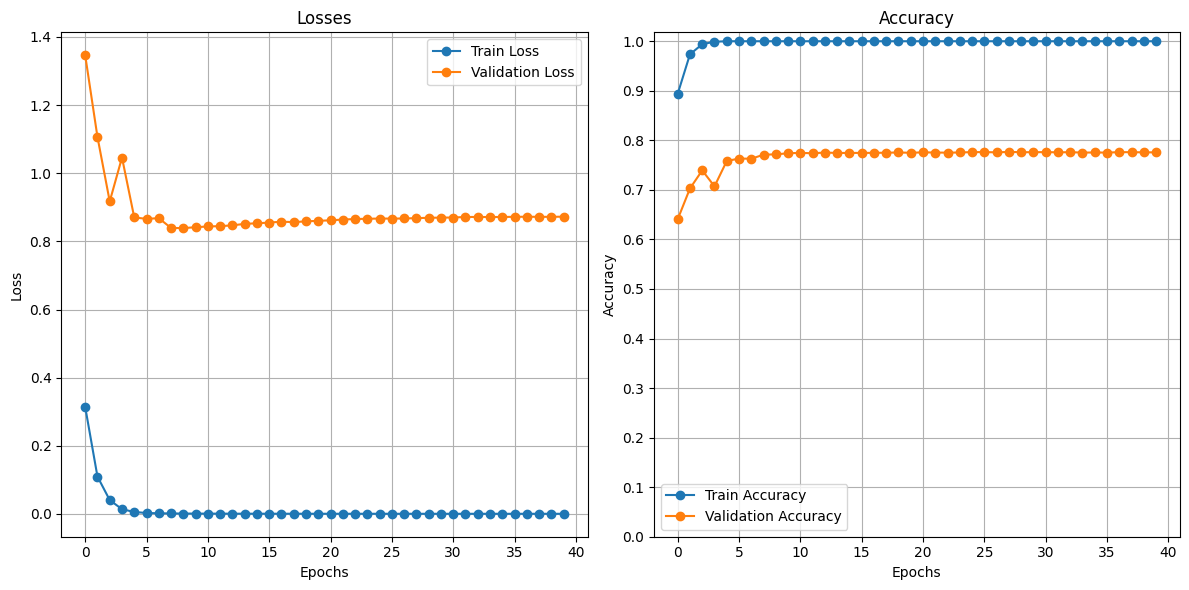

<module 'matplotlib.pyplot' from 'c:\\Users\\sever\\OneDrive\\Рабочий стол\\SSL\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [34]:
plot_results(results_fine_tuned, 'fine_tuned')


## 5. Supervised 2
(1.5 балл)

Снова обучите модель с нуля на размеченной части датасета (обучение на `train`, валидация на `test`), на этот раз используя набор из стандартных аугментаций картинок (например, можно взять трансформации с семинара по аугментациям). Получается ли приблизиться к качеству (предобучения на поворотах + дообучения на исходной классификации)? Какая комбинация аугментаций дает лучшее качество?



In [ ]:
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

batch_size = 512

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4467, 0.4398, 0.4066], std=[0.2603, 0.2566, 0.2713])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4467, 0.4398, 0.4066], std=[0.2603, 0.2566, 0.2713])
])

train_dataset_transformed = datasets.STL10(root='./data', split='train', download=True, transform=transform_train)
test_dataset_transformed = datasets.STL10(root='./data', split='test', download=True, transform=transform_test)

train_loader_transformed = DataLoader(train_dataset_transformed, batch_size=batch_size, shuffle=True)
test_loader_transformed = DataLoader(test_dataset_transformed, batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_transformed = models.resnet18(pretrained=False)
model_transformed.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_transformed.fc = nn.Linear(model_transformed.fc.in_features, 10)
model_transformed = model_transformed.to(device)

learning_rate = 0.001
num_epochs = 40
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_transformed.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
scaler = torch.amp.GradScaler()

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    print(f"Эпоха {epoch + 1}/{num_epochs}")
    train_loss, train_acc = train(model_transformed, train_loader_transformed, criterion, optimizer, scaler, device)
    val_loss, val_acc = validate(model_transformed, test_loader_transformed, criterion, device)

    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Потери на обучении: {train_loss:.4f}, Точность на обучении: {train_acc:.4f}")
    print(f"Потери на валидации: {val_loss:.4f}, Точность на валидации: {val_acc:.4f}")


transformed_results = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accs": train_accs,
    "val_accs": val_accs
}
torch.save(transformed_results, "transformed_results.pth")
torch.save(model_transformed.state_dict(), "model_transformed_weights.pth")

c:\Users\sever\OneDrive\Рабочий стол\SSL\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sever\OneDrive\Рабочий стол\SSL\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Эпоха 1/40


Потери на обучении: 2.1655, Точность на обучении: 0.2370
Потери на валидации: 9.1877, Точность на валидации: 0.1121
Эпоха 2/40


Потери на обучении: 1.6034, Точность на обучении: 0.3806
Потери на валидации: 2.4805, Точность на валидации: 0.2525
Эпоха 3/40


Потери на обучении: 1.4262, Точность на обучении: 0.4530
Потери на валидации: 1.7131, Точность на валидации: 0.4104
Эпоха 4/40


Потери на обучении: 1.3134, Точность на обучении: 0.5084
Потери на валидации: 1.4531, Точность на валидации: 0.4709
Эпоха 5/40


Потери на обучении: 1.2060, Точность на обучении: 0.5510
Потери на валидации: 1.6492, Точность на валидации: 0.4275
Эпоха 6/40


Потери на обучении: 1.1173, Точность на обучении: 0.5846
Потери на валидации: 1.4529, Точность на валидации: 0.4959
Эпоха 7/40


Потери на обучении: 1.0524, Точность на обучении: 0.6142
Потери на валидации: 1.1879, Точность на валидации: 0.5707
Эпоха 8/40


Потери на обучении: 1.0124, Точность на обучении: 0.6310
Потери на валидации: 1.5673, Точность на валидации: 0.4923
Эпоха 9/40


Потери на обучении: 0.9262, Точность на обучении: 0.6540
Потери на валидации: 1.1876, Точность на валидации: 0.5834
Эпоха 10/40


Потери на обучении: 0.8404, Точность на обучении: 0.6978
Потери на валидации: 1.0713, Точность на валидации: 0.6181
Эпоха 11/40


Потери на обучении: 0.8356, Точность на обучении: 0.6932
Потери на валидации: 1.2878, Точность на валидации: 0.5550
Эпоха 12/40


Потери на обучении: 0.7861, Точность на обучении: 0.7110
Потери на валидации: 1.1293, Точность на валидации: 0.6156
Эпоха 13/40


Потери на обучении: 0.7414, Точность на обучении: 0.7310
Потери на валидации: 1.0286, Точность на валидации: 0.6416
Эпоха 14/40


Потери на обучении: 0.7023, Точность на обучении: 0.7462
Потери на валидации: 1.1757, Точность на валидации: 0.5964
Эпоха 15/40


Потери на обучении: 0.6449, Точность на обучении: 0.7720
Потери на валидации: 0.9707, Точность на валидации: 0.6685
Эпоха 16/40


Потери на обучении: 0.6231, Точность на обучении: 0.7766
Потери на валидации: 0.9518, Точность на валидации: 0.6766
Эпоха 17/40


Потери на обучении: 0.6024, Точность на обучении: 0.7834
Потери на валидации: 0.9965, Точность на валидации: 0.6743
Эпоха 18/40


Потери на обучении: 0.5790, Точность на обучении: 0.7988
Потери на валидации: 1.0864, Точность на валидации: 0.6385
Эпоха 19/40


Потери на обучении: 0.5315, Точность на обучении: 0.8106
Потери на валидации: 1.0064, Точность на валидации: 0.6654
Эпоха 20/40


Потери на обучении: 0.4963, Точность на обучении: 0.8194
Потери на валидации: 1.0746, Точность на валидации: 0.6621
Эпоха 21/40


Потери на обучении: 0.4416, Точность на обучении: 0.8444
Потери на валидации: 0.9063, Точность на валидации: 0.6956
Эпоха 22/40


Потери на обучении: 0.4050, Точность на обучении: 0.8616
Потери на валидации: 0.9639, Точность на валидации: 0.6906
Эпоха 23/40


Потери на обучении: 0.3903, Точность на обучении: 0.8610
Потери на валидации: 0.8921, Точность на валидации: 0.7161
Эпоха 24/40


Потери на обучении: 0.3577, Точность на обучении: 0.8792
Потери на валидации: 0.8721, Точность на валидации: 0.7095
Эпоха 25/40


Потери на обучении: 0.3060, Точность на обучении: 0.8910
Потери на валидации: 1.0150, Точность на валидации: 0.6984
Эпоха 26/40


Потери на обучении: 0.3028, Точность на обучении: 0.8940
Потери на валидации: 0.9439, Точность на валидации: 0.7130
Эпоха 27/40


Потери на обучении: 0.2663, Точность на обучении: 0.9132
Потери на валидации: 0.8594, Точность на валидации: 0.7262
Эпоха 28/40


Потери на обучении: 0.2366, Точность на обучении: 0.9222
Потери на валидации: 0.8199, Точность на валидации: 0.7458
Эпоха 29/40


Потери на обучении: 0.2195, Точность на обучении: 0.9288
Потери на валидации: 0.8074, Точность на валидации: 0.7439
Эпоха 30/40


Потери на обучении: 0.1825, Точность на обучении: 0.9450
Потери на валидации: 0.8395, Точность на валидации: 0.7372
Эпоха 31/40


Потери на обучении: 0.1756, Точность на обучении: 0.9490
Потери на валидации: 0.8244, Точность на валидации: 0.7462
Эпоха 32/40


Потери на обучении: 0.1575, Точность на обучении: 0.9560
Потери на валидации: 0.8335, Точность на валидации: 0.7506
Эпоха 33/40


Потери на обучении: 0.1414, Точность на обучении: 0.9596
Потери на валидации: 0.8393, Точность на валидации: 0.7518
Эпоха 34/40


Потери на обучении: 0.1294, Точность на обучении: 0.9634
Потери на валидации: 0.7965, Точность на валидации: 0.7590
Эпоха 35/40


Потери на обучении: 0.1151, Точность на обучении: 0.9718
Потери на валидации: 0.8034, Точность на валидации: 0.7579
Эпоха 36/40


Потери на обучении: 0.1110, Точность на обучении: 0.9708
Потери на валидации: 0.8059, Точность на валидации: 0.7584
Эпоха 37/40


Потери на обучении: 0.1044, Точность на обучении: 0.9746
Потери на валидации: 0.8054, Точность на валидации: 0.7594
Эпоха 38/40


Потери на обучении: 0.1105, Точность на обучении: 0.9738
Потери на валидации: 0.7965, Точность на валидации: 0.7609
Эпоха 39/40


Потери на обучении: 0.0962, Точность на обучении: 0.9780
Потери на валидации: 0.7947, Точность на валидации: 0.7616
Эпоха 40/40


Потери на обучении: 0.0990, Точность на обучении: 0.9752
Потери на валидации: 0.7948, Точность на валидации: 0.7622


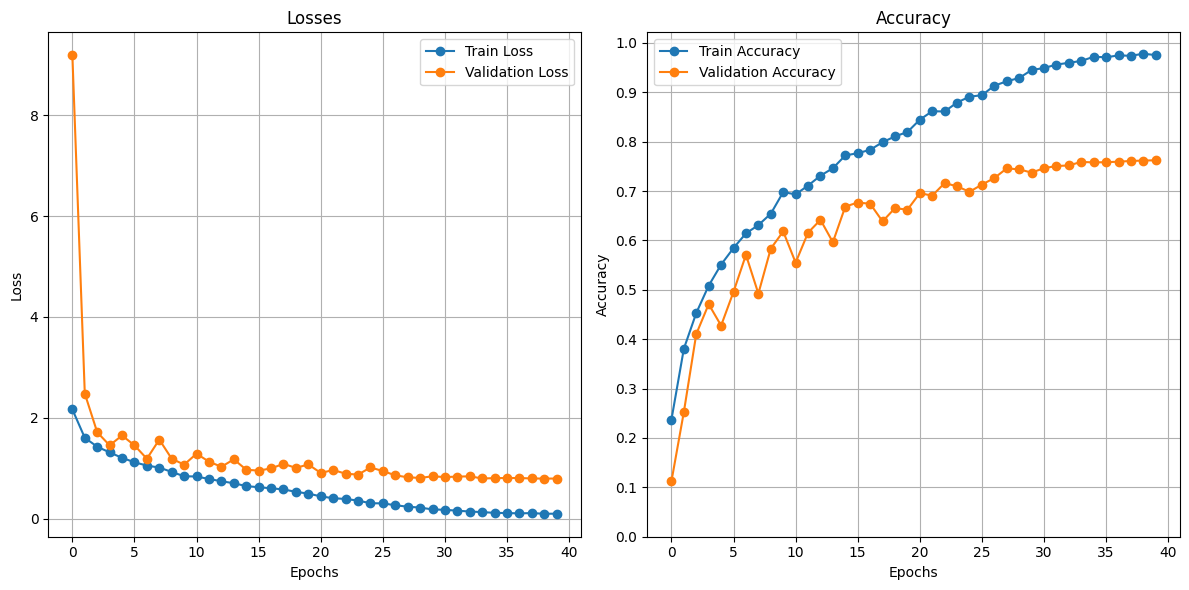

<module 'matplotlib.pyplot' from 'c:\\Users\\sever\\OneDrive\\Рабочий стол\\SSL\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [11]:
plot_results(transformed_results, 'transformed')


## 6. Transfer Learning
(1.5 балл)

Возьмите предобученную на задаче предсказания поворота модель (из пункта 1). Обучите новую линейную пробу / дообучите модель полностью на датасете CIFAR-10. Какого качества получается добиться на новом датасете? Что это говорит об универсальности полученных репрезентаций?



In [10]:
train_dataset_cifar =  datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset_cifar =  datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


train_loader_cifar = DataLoader(train_dataset_cifar, batch_size=batch_size, shuffle=True)
test_loader_cifar = DataLoader(test_dataset_cifar, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


# Дообучаем модель полностью

In [6]:
from torchvision import models
import copy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_rotated = models.resnet18(pretrained=False)
model_rotated.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_rotated.fc = nn.Linear(model_rotated.fc.in_features, 4)
model_rotated = model_rotated.to(device)

model_rotated.load_state_dict(torch.load('rotated_weights.pth'))

c:\Users\sever\OneDrive\Рабочий стол\SSL\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sever\OneDrive\Рабочий стол\SSL\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\sever\AppData\Local\Temp\ipykernel_18216\2858566286.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the de

<All keys matched successfully>

In [8]:
from torchvision import models
import copy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_transfer_all = models.resnet18(pretrained=False)
model_transfer_all.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_transfer_all.fc = nn.Linear(model_transfer_all.fc.in_features, 4)
model_transfer_all = model_transfer_all.to(device)

model_transfer_all = copy.deepcopy(model_rotated)
model_transfer_all = model_transfer_all.to(device)


c:\Users\sever\OneDrive\Рабочий стол\SSL\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sever\OneDrive\Рабочий стол\SSL\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [11]:
# Размораживаем все слои модели
for param in model_transfer_all.parameters():
    param.requires_grad = True

model_transfer_all.fc = nn.Linear(model_transfer_all.fc.in_features, 10)
model_transfer = model_transfer_all.to(device)

learning_rate = 0.001
num_epochs = 40
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_transfer_all.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
scaler = torch.amp.GradScaler()

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in tqdm(range(num_epochs)):
    print(f"Эпоха {epoch + 1}/{num_epochs}")
    train_loss, train_acc = train(model_transfer_all, train_loader_cifar, criterion, optimizer, scaler, device)
    val_loss, val_acc = validate(model_transfer_all, test_loader_cifar, criterion, device)

    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Потери на обучении: {train_loss:.4f}, Точность на обучении: {train_acc:.4f}")
    print(f"Потери на валидации: {val_loss:.4f}, Точность на валидации: {val_acc:.4f}")

results_transfer_all = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accs": train_accs,
    "val_accs": val_accs
}
torch.save(results_transfer_all, "model_transfer_results.pth")
torch.save(model_transfer_all.state_dict(), "model_transfer_weights.pth")

  0%|          | 0/40 [00:00<?, ?it/s]

Эпоха 1/40


  2%|▎         | 1/40 [00:04<03:00,  4.62s/it]

Потери на обучении: 0.8689, Точность на обучении: 0.6951
Потери на валидации: 0.7558, Точность на валидации: 0.7398
Эпоха 2/40


  5%|▌         | 2/40 [00:08<02:38,  4.17s/it]

Потери на обучении: 0.4698, Точность на обучении: 0.8377
Потери на валидации: 0.6930, Точность на валидации: 0.7667
Эпоха 3/40


  8%|▊         | 3/40 [00:12<02:27,  3.99s/it]

Потери на обучении: 0.2814, Точность на обучении: 0.9034
Потери на валидации: 0.6789, Точность на валидации: 0.7850
Эпоха 4/40


 10%|█         | 4/40 [00:16<02:22,  3.95s/it]

Потери на обучении: 0.1673, Точность на обучении: 0.9416
Потери на валидации: 0.8578, Точность на валидации: 0.7718
Эпоха 5/40


 12%|█▎        | 5/40 [00:19<02:16,  3.91s/it]

Потери на обучении: 0.0986, Точность на обучении: 0.9668
Потери на валидации: 0.9110, Точность на валидации: 0.7820
Эпоха 6/40


 15%|█▌        | 6/40 [00:23<02:13,  3.93s/it]

Потери на обучении: 0.0742, Точность на обучении: 0.9745
Потери на валидации: 1.0584, Точность на валидации: 0.7731
Эпоха 7/40


 18%|█▊        | 7/40 [00:27<02:09,  3.93s/it]

Потери на обучении: 0.0525, Точность на обучении: 0.9816
Потери на валидации: 0.9713, Точность на валидации: 0.7948
Эпоха 8/40


 20%|██        | 8/40 [00:31<02:05,  3.93s/it]

Потери на обучении: 0.0428, Точность на обучении: 0.9856
Потери на валидации: 0.9534, Точность на валидации: 0.7995
Эпоха 9/40


 22%|██▎       | 9/40 [00:35<02:01,  3.92s/it]

Потери на обучении: 0.0332, Точность на обучении: 0.9887
Потери на валидации: 1.0513, Точность на валидации: 0.7946
Эпоха 10/40


 25%|██▌       | 10/40 [00:39<01:58,  3.94s/it]

Потери на обучении: 0.0314, Точность на обучении: 0.9892
Потери на валидации: 1.1233, Точность на валидации: 0.7929
Эпоха 11/40


 28%|██▊       | 11/40 [00:43<01:52,  3.90s/it]

Потери на обучении: 0.0221, Точность на обучении: 0.9925
Потери на валидации: 1.0164, Точность на валидации: 0.8033
Эпоха 12/40


 30%|███       | 12/40 [00:47<01:46,  3.81s/it]

Потери на обучении: 0.0181, Точность на обучении: 0.9939
Потери на валидации: 1.1459, Точность на валидации: 0.7975
Эпоха 13/40


 32%|███▎      | 13/40 [00:50<01:41,  3.78s/it]

Потери на обучении: 0.0159, Точность на обучении: 0.9950
Потери на валидации: 1.0679, Точность на валидации: 0.8121
Эпоха 14/40


 35%|███▌      | 14/40 [00:54<01:37,  3.74s/it]

Потери на обучении: 0.0108, Точность на обучении: 0.9964
Потери на валидации: 1.0518, Точность на валидации: 0.8179
Эпоха 15/40


 38%|███▊      | 15/40 [00:58<01:32,  3.68s/it]

Потери на обучении: 0.0128, Точность на обучении: 0.9958
Потери на валидации: 1.0676, Точность на валидации: 0.8203
Эпоха 16/40


 40%|████      | 16/40 [01:01<01:28,  3.67s/it]

Потери на обучении: 0.0107, Точность на обучении: 0.9963
Потери на валидации: 1.1175, Точность на валидации: 0.8166
Эпоха 17/40


 42%|████▎     | 17/40 [01:05<01:23,  3.65s/it]

Потери на обучении: 0.0098, Точность на обучении: 0.9967
Потери на валидации: 1.1030, Точность на валидации: 0.8142
Эпоха 18/40


 45%|████▌     | 18/40 [01:08<01:19,  3.63s/it]

Потери на обучении: 0.0059, Точность на обучении: 0.9980
Потери на валидации: 1.0812, Точность на валидации: 0.8206
Эпоха 19/40


 48%|████▊     | 19/40 [01:12<01:16,  3.63s/it]

Потери на обучении: 0.0029, Точность на обучении: 0.9992
Потери на валидации: 1.0692, Точность на валидации: 0.8263
Эпоха 20/40


 50%|█████     | 20/40 [01:16<01:12,  3.61s/it]

Потери на обучении: 0.0005, Точность на обучении: 1.0000
Потери на валидации: 1.0221, Точность на валидации: 0.8349
Эпоха 21/40


 52%|█████▎    | 21/40 [01:19<01:08,  3.61s/it]

Потери на обучении: 0.0002, Точность на обучении: 1.0000
Потери на валидации: 1.0284, Точность на валидации: 0.8350
Эпоха 22/40


 55%|█████▌    | 22/40 [01:23<01:04,  3.59s/it]

Потери на обучении: 0.0001, Точность на обучении: 1.0000
Потери на валидации: 1.0286, Точность на валидации: 0.8341
Эпоха 23/40


 57%|█████▊    | 23/40 [01:26<01:01,  3.61s/it]

Потери на обучении: 0.0001, Точность на обучении: 1.0000
Потери на валидации: 1.0335, Точность на валидации: 0.8345
Эпоха 24/40


 60%|██████    | 24/40 [01:30<00:58,  3.63s/it]

Потери на обучении: 0.0001, Точность на обучении: 1.0000
Потери на валидации: 1.0350, Точность на валидации: 0.8356
Эпоха 25/40


 62%|██████▎   | 25/40 [01:34<00:54,  3.62s/it]

Потери на обучении: 0.0001, Точность на обучении: 1.0000
Потери на валидации: 1.0399, Точность на валидации: 0.8346
Эпоха 26/40


 65%|██████▌   | 26/40 [01:37<00:50,  3.63s/it]

Потери на обучении: 0.0001, Точность на обучении: 1.0000
Потери на валидации: 1.0413, Точность на валидации: 0.8342
Эпоха 27/40


 68%|██████▊   | 27/40 [01:41<00:47,  3.65s/it]

Потери на обучении: 0.0001, Точность на обучении: 1.0000
Потери на валидации: 1.0360, Точность на валидации: 0.8347
Эпоха 28/40


 70%|███████   | 28/40 [01:45<00:43,  3.65s/it]

Потери на обучении: 0.0000, Точность на обучении: 1.0000
Потери на валидации: 1.0422, Точность на валидации: 0.8343
Эпоха 29/40


 72%|███████▎  | 29/40 [01:48<00:40,  3.64s/it]

Потери на обучении: 0.0000, Точность на обучении: 1.0000
Потери на валидации: 1.0395, Точность на валидации: 0.8354
Эпоха 30/40


 75%|███████▌  | 30/40 [01:52<00:36,  3.62s/it]

Потери на обучении: 0.0000, Точность на обучении: 1.0000
Потери на валидации: 1.0426, Точность на валидации: 0.8355
Эпоха 31/40


 78%|███████▊  | 31/40 [01:55<00:32,  3.61s/it]

Потери на обучении: 0.0000, Точность на обучении: 1.0000
Потери на валидации: 1.0409, Точность на валидации: 0.8354
Эпоха 32/40


 80%|████████  | 32/40 [01:59<00:28,  3.61s/it]

Потери на обучении: 0.0000, Точность на обучении: 1.0000
Потери на валидации: 1.0463, Точность на валидации: 0.8346
Эпоха 33/40


 82%|████████▎ | 33/40 [02:03<00:25,  3.62s/it]

Потери на обучении: 0.0000, Точность на обучении: 1.0000
Потери на валидации: 1.0456, Точность на валидации: 0.8355
Эпоха 34/40


 85%|████████▌ | 34/40 [02:06<00:21,  3.63s/it]

Потери на обучении: 0.0000, Точность на обучении: 1.0000
Потери на валидации: 1.0460, Точность на валидации: 0.8355
Эпоха 35/40


 88%|████████▊ | 35/40 [02:10<00:18,  3.64s/it]

Потери на обучении: 0.0000, Точность на обучении: 1.0000
Потери на валидации: 1.0423, Точность на валидации: 0.8348
Эпоха 36/40


 90%|█████████ | 36/40 [02:14<00:14,  3.65s/it]

Потери на обучении: 0.0000, Точность на обучении: 1.0000
Потери на валидации: 1.0467, Точность на валидации: 0.8347
Эпоха 37/40


 92%|█████████▎| 37/40 [02:17<00:10,  3.62s/it]

Потери на обучении: 0.0000, Точность на обучении: 1.0000
Потери на валидации: 1.0472, Точность на валидации: 0.8351
Эпоха 38/40


 95%|█████████▌| 38/40 [02:21<00:07,  3.62s/it]

Потери на обучении: 0.0000, Точность на обучении: 1.0000
Потери на валидации: 1.0429, Точность на валидации: 0.8351
Эпоха 39/40


 98%|█████████▊| 39/40 [02:24<00:03,  3.61s/it]

Потери на обучении: 0.0000, Точность на обучении: 1.0000
Потери на валидации: 1.0460, Точность на валидации: 0.8356
Эпоха 40/40


100%|██████████| 40/40 [02:28<00:00,  3.71s/it]

Потери на обучении: 0.0000, Точность на обучении: 1.0000
Потери на валидации: 1.0480, Точность на валидации: 0.8351


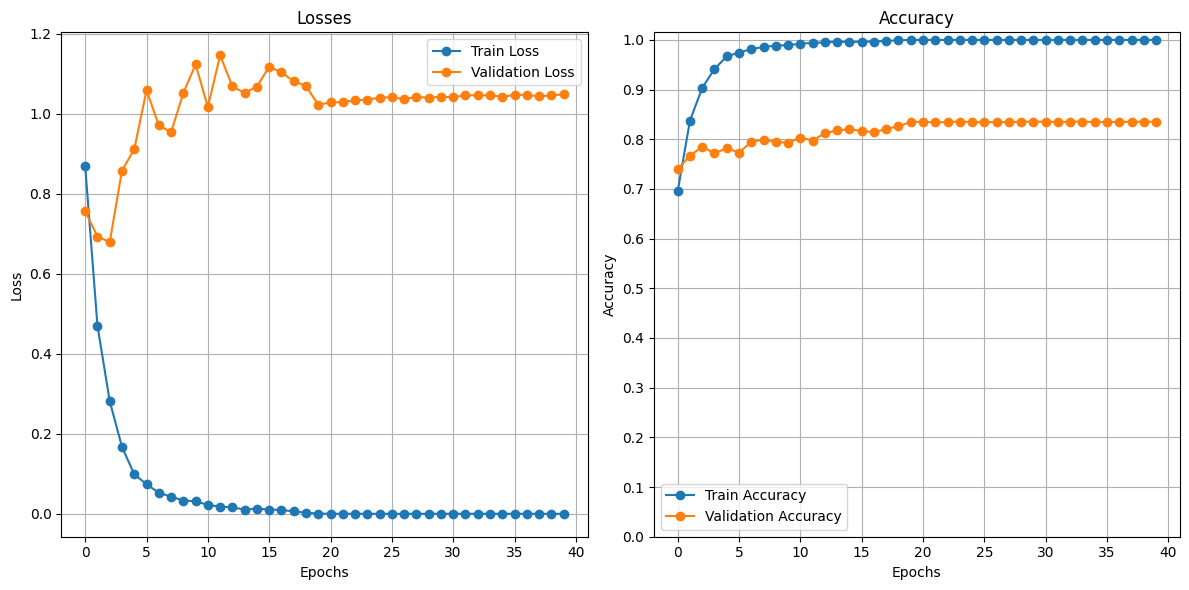

<module 'matplotlib.pyplot' from 'c:\\Users\\sever\\OneDrive\\Рабочий стол\\SSL\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [15]:
plot_results(results_transfer_all, 'transfer_all')

# Линейная проба

In [16]:
from torchvision import models
import copy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_transfer_fc = models.resnet18(pretrained=False)
model_transfer_fc.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_transfer_fc.fc = nn.Linear(model_transfer_fc.fc.in_features, 4)
model_transfer_fc = model_transfer_all.to(device)

model_transfer_fc = copy.deepcopy(model_rotated)
model_transfer_fc = model_transfer_fc.to(device)


c:\Users\sever\OneDrive\Рабочий стол\SSL\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sever\OneDrive\Рабочий стол\SSL\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [17]:
# Размораживаем все слои модели
for param in model_transfer_fc.parameters():
    param.requires_grad = False

model_transfer_fc.fc = nn.Linear(model_transfer_fc.fc.in_features, 10)
model_transfer_fc = model_transfer_fc.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(model_transfer_fc.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
scaler = torch.amp.GradScaler()

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in tqdm(range(num_epochs)):
    print(f"Эпоха {epoch + 1}/{num_epochs}")
    train_loss, train_acc = train(model_transfer_fc, train_loader_cifar, criterion, optimizer, scaler, device)
    val_loss, val_acc = validate(model_transfer_fc, test_loader_cifar, criterion, device)

    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Потери на обучении: {train_loss:.4f}, Точность на обучении: {train_acc:.4f}")
    print(f"Потери на валидации: {val_loss:.4f}, Точность на валидации: {val_acc:.4f}")

results_transfer_fc = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accs": train_accs,
    "val_accs": val_accs
}
torch.save(results_transfer_fc, "model_transfer_fc_results.pth")
torch.save(model_transfer_fc.state_dict(), "model_transfer_fc_weights.pth")

  0%|          | 0/40 [00:00<?, ?it/s]

Эпоха 1/40


  2%|▎         | 1/40 [00:03<02:12,  3.41s/it]

Потери на обучении: 1.9873, Точность на обучении: 0.3018
Потери на валидации: 1.7688, Точность на валидации: 0.4021
Эпоха 2/40


  5%|▌         | 2/40 [00:06<02:10,  3.45s/it]

Потери на обучении: 1.6972, Точность на обучении: 0.4284
Потери на валидации: 1.6224, Точность на валидации: 0.4451
Эпоха 3/40


  8%|▊         | 3/40 [00:10<02:11,  3.55s/it]

Потери на обучении: 1.5845, Точность на обучении: 0.4636
Потери на валидации: 1.5449, Точность на валидации: 0.4695
Эпоха 4/40


 10%|█         | 4/40 [00:14<02:11,  3.65s/it]

Потери на обучении: 1.5218, Точность на обучении: 0.4824
Потери на валидации: 1.4967, Точность на валидации: 0.4841
Эпоха 5/40


 12%|█▎        | 5/40 [00:18<02:09,  3.70s/it]

Потери на обучении: 1.4787, Точность на обучении: 0.4978
Потери на валидации: 1.4545, Точность на валидации: 0.4996
Эпоха 6/40


 15%|█▌        | 6/40 [00:22<02:07,  3.76s/it]

Потери на обучении: 1.4462, Точность на обучении: 0.5081
Потери на валидации: 1.4267, Точность на валидации: 0.5087
Эпоха 7/40


 18%|█▊        | 7/40 [00:25<02:05,  3.81s/it]

Потери на обучении: 1.4228, Точность на обучении: 0.5146
Потери на валидации: 1.4080, Точность на валидации: 0.5183
Эпоха 8/40


 20%|██        | 8/40 [00:29<02:02,  3.83s/it]

Потери на обучении: 1.4026, Точность на обучении: 0.5212
Потери на валидации: 1.3861, Точность на валидации: 0.5243
Эпоха 9/40


 22%|██▎       | 9/40 [00:33<01:59,  3.85s/it]

Потери на обучении: 1.3868, Точность на обучении: 0.5264
Потери на валидации: 1.3843, Точность на валидации: 0.5184
Эпоха 10/40


 25%|██▌       | 10/40 [00:37<01:55,  3.84s/it]

Потери на обучении: 1.3715, Точность на обучении: 0.5326
Потери на валидации: 1.3689, Точность на валидации: 0.5268
Эпоха 11/40


 28%|██▊       | 11/40 [00:41<01:50,  3.82s/it]

Потери на обучении: 1.3596, Точность на обучении: 0.5357
Потери на валидации: 1.3598, Точность на валидации: 0.5324
Эпоха 12/40


 30%|███       | 12/40 [00:45<01:46,  3.82s/it]

Потери на обучении: 1.3494, Точность на обучении: 0.5385
Потери на валидации: 1.3503, Точность на валидации: 0.5365
Эпоха 13/40


 32%|███▎      | 13/40 [00:48<01:42,  3.80s/it]

Потери на обучении: 1.3397, Точность на обучении: 0.5416
Потери на валидации: 1.3420, Точность на валидации: 0.5377
Эпоха 14/40


 35%|███▌      | 14/40 [00:52<01:38,  3.79s/it]

Потери на обучении: 1.3324, Точность на обучении: 0.5443
Потери на валидации: 1.3357, Точность на валидации: 0.5382
Эпоха 15/40


 38%|███▊      | 15/40 [00:56<01:34,  3.79s/it]

Потери на обучении: 1.3249, Точность на обучении: 0.5468
Потери на валидации: 1.3283, Точность на валидации: 0.5435
Эпоха 16/40


 40%|████      | 16/40 [01:00<01:30,  3.79s/it]

Потери на обучении: 1.3176, Точность на обучении: 0.5488
Потери на валидации: 1.3232, Точность на валидации: 0.5490
Эпоха 17/40


 42%|████▎     | 17/40 [01:04<01:27,  3.79s/it]

Потери на обучении: 1.3123, Точность на обучении: 0.5515
Потери на валидации: 1.3180, Точность на валидации: 0.5490
Эпоха 18/40


 45%|████▌     | 18/40 [01:07<01:23,  3.78s/it]

Потери на обучении: 1.3077, Точность на обучении: 0.5526
Потери на валидации: 1.3163, Точность на валидации: 0.5495
Эпоха 19/40


 48%|████▊     | 19/40 [01:11<01:19,  3.77s/it]

Потери на обучении: 1.3018, Точность на обучении: 0.5549
Потери на валидации: 1.3136, Точность на валидации: 0.5479
Эпоха 20/40


 50%|█████     | 20/40 [01:15<01:13,  3.69s/it]

Потери на обучении: 1.2977, Точность на обучении: 0.5553
Потери на валидации: 1.3076, Точность на валидации: 0.5514
Эпоха 21/40


 52%|█████▎    | 21/40 [01:18<01:09,  3.65s/it]

Потери на обучении: 1.2943, Точность на обучении: 0.5565
Потери на валидации: 1.3045, Точность на валидации: 0.5527
Эпоха 22/40


 55%|█████▌    | 22/40 [01:22<01:05,  3.64s/it]

Потери на обучении: 1.2906, Точность на обучении: 0.5582
Потери на валидации: 1.3035, Точность на валидации: 0.5518
Эпоха 23/40


 57%|█████▊    | 23/40 [01:25<01:01,  3.62s/it]

Потери на обучении: 1.2877, Точность на обучении: 0.5591
Потери на валидации: 1.3011, Точность на валидации: 0.5532
Эпоха 24/40


 60%|██████    | 24/40 [01:29<00:58,  3.63s/it]

Потери на обучении: 1.2857, Точность на обучении: 0.5605
Потери на валидации: 1.2982, Точность на валидации: 0.5529
Эпоха 25/40


 62%|██████▎   | 25/40 [01:33<00:54,  3.64s/it]

Потери на обучении: 1.2827, Точность на обучении: 0.5612
Потери на валидации: 1.2970, Точность на валидации: 0.5551
Эпоха 26/40


 65%|██████▌   | 26/40 [01:36<00:51,  3.66s/it]

Потери на обучении: 1.2807, Точность на обучении: 0.5621
Потери на валидации: 1.2970, Точность на валидации: 0.5542
Эпоха 27/40


 68%|██████▊   | 27/40 [01:40<00:47,  3.64s/it]

Потери на обучении: 1.2788, Точность на обучении: 0.5617
Потери на валидации: 1.2930, Точность на валидации: 0.5551
Эпоха 28/40


 70%|███████   | 28/40 [01:44<00:43,  3.64s/it]

Потери на обучении: 1.2769, Точность на обучении: 0.5623
Потери на валидации: 1.2921, Точность на валидации: 0.5581
Эпоха 29/40


 72%|███████▎  | 29/40 [01:47<00:40,  3.65s/it]

Потери на обучении: 1.2751, Точность на обучении: 0.5641
Потери на валидации: 1.2909, Точность на валидации: 0.5576
Эпоха 30/40


 75%|███████▌  | 30/40 [01:51<00:36,  3.66s/it]

Потери на обучении: 1.2735, Точность на обучении: 0.5636
Потери на валидации: 1.2911, Точность на валидации: 0.5561
Эпоха 31/40


 78%|███████▊  | 31/40 [01:55<00:32,  3.66s/it]

Потери на обучении: 1.2729, Точность на обучении: 0.5645
Потери на валидации: 1.2901, Точность на валидации: 0.5562
Эпоха 32/40


 80%|████████  | 32/40 [01:58<00:29,  3.65s/it]

Потери на обучении: 1.2710, Точность на обучении: 0.5655
Потери на валидации: 1.2888, Точность на валидации: 0.5568
Эпоха 33/40


 82%|████████▎ | 33/40 [02:02<00:25,  3.67s/it]

Потери на обучении: 1.2697, Точность на обучении: 0.5653
Потери на валидации: 1.2890, Точность на валидации: 0.5570
Эпоха 34/40


 85%|████████▌ | 34/40 [02:06<00:22,  3.67s/it]

Потери на обучении: 1.2701, Точность на обучении: 0.5644
Потери на валидации: 1.2878, Точность на валидации: 0.5579
Эпоха 35/40


 88%|████████▊ | 35/40 [02:09<00:18,  3.65s/it]

Потери на обучении: 1.2687, Точность на обучении: 0.5651
Потери на валидации: 1.2878, Точность на валидации: 0.5579
Эпоха 36/40


 90%|█████████ | 36/40 [02:13<00:14,  3.64s/it]

Потери на обучении: 1.2687, Точность на обучении: 0.5657
Потери на валидации: 1.2865, Точность на валидации: 0.5575
Эпоха 37/40


 92%|█████████▎| 37/40 [02:16<00:10,  3.64s/it]

Потери на обучении: 1.2680, Точность на обучении: 0.5667
Потери на валидации: 1.2861, Точность на валидации: 0.5569
Эпоха 38/40


 95%|█████████▌| 38/40 [02:20<00:07,  3.63s/it]

Потери на обучении: 1.2688, Точность на обучении: 0.5663
Потери на валидации: 1.2867, Точность на валидации: 0.5570
Эпоха 39/40


 98%|█████████▊| 39/40 [02:24<00:03,  3.61s/it]

Потери на обучении: 1.2677, Точность на обучении: 0.5660
Потери на валидации: 1.2866, Точность на валидации: 0.5574
Эпоха 40/40


100%|██████████| 40/40 [02:27<00:00,  3.70s/it]

Потери на обучении: 1.2679, Точность на обучении: 0.5656
Потери на валидации: 1.2868, Точность на валидации: 0.5570


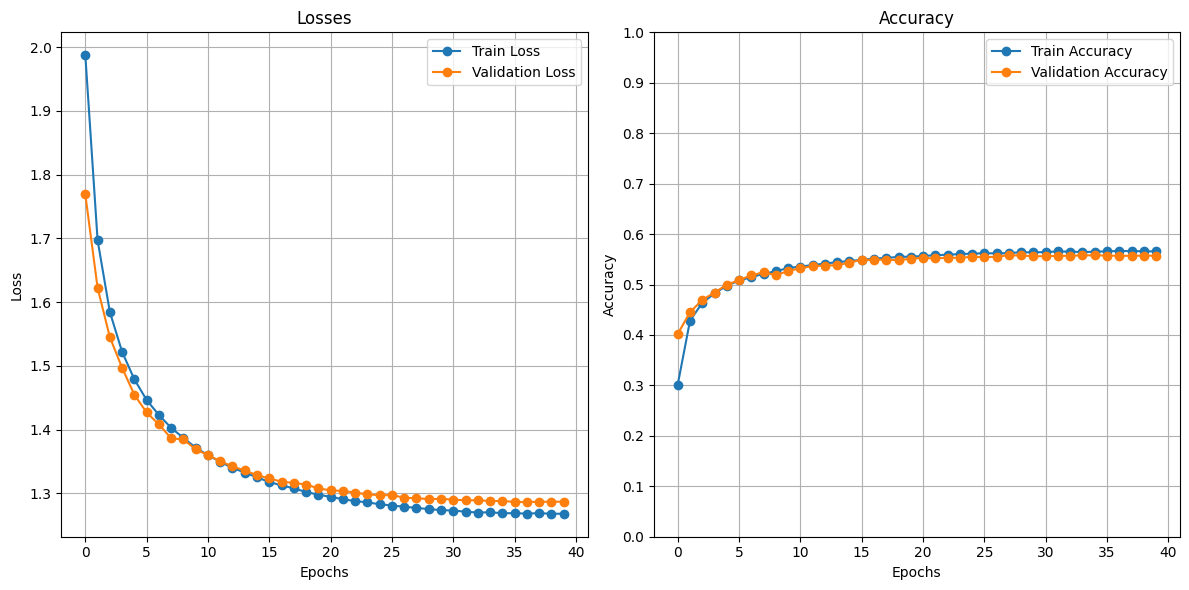

<module 'matplotlib.pyplot' from 'c:\\Users\\sever\\OneDrive\\Рабочий стол\\SSL\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [18]:
plot_results(results_transfer_fc, 'transfer_fc')


**NB** **Бонусный** балл за красиво оформленный отчет.